# Notebook to create OF figures for manuscrip.

Imports

In [10]:
%matplotlib inline

from pathlib import Path
from types import SimpleNamespace
from joblib import delayed, Parallel
import time
import traceback

import numpy as np
import pandas as pd
import scipy.stats as stats
pd.set_option('display.max_rows', 50)

import matplotlib as mpl

import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.path as mpath
import seaborn as sns
sns.set(style='whitegrid', palette='muted')
from matplotlib_venn import venn2, venn3

## added TreeMazeanalyses folder using the following command
## conda develop /home/alexgonzalez/Documents/TreeMazeAnalyses2
import TreeMazeAnalyses2.Utils.robust_stats as rs

from TreeMazeAnalyses2.Analyses.subject_info import SubjectInfo, SubjectSessionInfo
from TreeMazeAnalyses2.Analyses import spatial_functions as spatial_funcs
import TreeMazeAnalyses2.Analyses.open_field_functions as of_funcs

from TreeMazeAnalyses2.Analyses import cluster_match_functions as cmf

from importlib import reload

import ipywidgets as widgets
from ipywidgets import interact, fixed, interact_manual
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

Defaults

In [3]:
subjects = ['Li', 'Ne', 'Cl', 'Al', 'Ca', 'Mi']
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
analyses_colors = sns.color_palette(palette='deep', as_cmap=True)
type_color = {'hd': analyses_colors[0],
              'speed': analyses_colors[1],
              'border': analyses_colors[2],
              'grid': analyses_colors[3],
              'pos': analyses_colors[4]}

gd_results_path = Path("/home/alexgonzalez/google-drive/TreeMazeProject/Results_Summary/")
local_results_path = Path("/mnt/Data_HD2T/SummaryData/")

fig5_path = Path("/home/alexgonzalez/google-drive/TreeMazeProject/Figures/OF_Fig/")

units_table_fn = "all_units_table.csv"
metric_scores_fn = 'of_metric_scores_summary_table.csv'
model_scores_fn = 'of_model_scores_summary_table.csv'

Load data

In [11]:
metric_scores = pd.read_csv(local_results_path / metric_scores_fn, index_col=0)
model_scores = pd.read_csv(local_results_path / model_scores_fn, index_col=0)
unit_table = pd.read_csv(local_results_path / units_table_fn, index_col=0)

## correct scores tables for erronous session

In [12]:
invalid_sessions = ['Li_OF_080718'] ## mislabeled session

for session in invalid_sessions:
    unit_idx = unit_table[unit_table.session==session].unique_cl_name
    metric_scores.loc[metric_scores.cl_name.isin(unit_idx), 'session_valid'] = False
    model_scores.loc[model_scores.cl_name.isin(unit_idx), 'session_valid'] = False

In [9]:
metric_scores[(metric_scores.session=='Li_OF_070618') & (metric_scores.analysis_type=='grid')].head()

unit_id subject       session  session_pct_cov  session_valid  \
4528      905      Ne  NE_OF_061418             0.03          False   

      session_unit_id unit_type  tt  tt_cl                      cl_name  \
4528                0       mua  13      5  NE_OF_061418-tt13_d15.0_cl5   

     analysis_type  score  sig  
4528          grid    NaN  0.0

(array([ 15.,  79., 135.,  69.,  10.,   4.,   1.,   0.,   0.,   1.]),
 array([-0.36196997, -0.26000605, -0.15804213, -0.0560782 ,  0.04588572,
         0.14784964,  0.24981357,  0.35177749,  0.45374141,  0.55570534,
         0.65766926]),
 <a list of 10 Patch objects>)

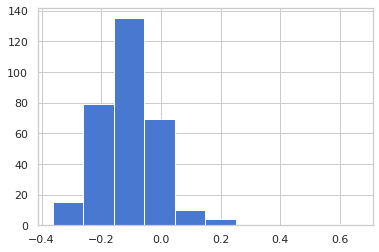

In [7]:
plt.hist(metric_scores[(metric_scores.analysis_type=='grid') & (metric_scores.unit_type=='cell') & (metric_scores.session_valid)].score)

In [8]:
model_scores[(model_scores.session=='NE_OF_061418') & (model_scores.model=='pos') & (model_scores.metric=='r2') ].head()

Empty DataFrame
Columns: [unit_id, subject, session, session_unit_id, unit_type, session_pct_cov, session_valid, tt, tt_cl, model, split, metric, value, cl_name]
Index: []

## select example cell

In [13]:
analyses=['speed','hd','border','grid', 'stability']
@interact(analysis_type=analyses, unit_type=['cell', 'mua', None], thr=widgets.FloatSlider(min=-1, max=1, step=0.02))
def metric_filter_units(analysis_type, thr, unit_type=None):
    if unit_type is None:
        sub_table = metric_scores.loc[ (metric_scores.analysis_type==analysis_type) 
                                      & (metric_scores.score>=thr) 
                                      & (metric_scores.session_valid)]
    else:
        sub_table = metric_scores.loc[ (metric_scores.unit_type==unit_type) 
                                      & (metric_scores.analysis_type==analysis_type) 
                                      & (metric_scores.score>=thr)
                                      & (metric_scores.session_valid)]
    return sub_table.sort_values(by=['score'], ascending=False)
        

interactive(children=(Dropdown(description='analysis_type', options=('speed', 'hd', 'border', 'grid', 'stabili…

In [16]:
@interact(model=['speed','hd','border','grid', 'pos', 'agg'], thr=widgets.FloatSlider(min=-1, max=1, step=0.02), unit_type=['cell', 'mua', None], model_metric=['r2', 'map_r', 'n_err', 'coef', 'agg_coef'], split=['train', 'test'] )
def model_filter_units(model, thr, model_metric, split, unit_type=None):
    if unit_type is None:
        sub_table = model_scores.loc[ (model_scores.model==model)
                                      & (model_scores.metric==model_metric)
                                      & (model_scores.split==split) 
                                      & (model_scores.value>=thr) 
                                      & (model_scores.session_valid)]
    else:
        sub_table = model_scores.loc[ (model_scores.unit_type==unit_type) 
                                      & (model_scores.model==model)
                                      & (model_scores.metric==model_metric)
                                      & (model_scores.split==split) 
                                      & (model_scores.value>=thr) 
                                      & (model_scores.session_valid)]

    return sub_table.sort_values(by=['value'], ascending=False)


interactive(children=(Dropdown(description='model', options=('speed', 'hd', 'border', 'grid', 'pos', 'agg'), v…

Helper functions

In [753]:
label_fontsize = 14

def get_bin_ang_fr(track_data, fr, bin_step= np.pi/18, min_speed=3):
    hd = track_data['hd']
    sp = track_data['sp']
    
    speed_valid_idx = sp>=min_speed 
    hd2 = hd[speed_valid_idx]
    fr2 = fr[speed_valid_idx]
    
    res, ang_fr, ang_bin_centers, ang_bin_edges = spatial_funcs.get_angle_stats(hd2, bin_step, weights=fr2)
    res['vec_len'] = np.abs(np.mean(ang_fr*np.exp(ang_bin_centers*1j)))
    res['ang_fr'] = ang_fr
    res['ang_bin_centers'] = ang_bin_centers
    res['ang_bin_edges'] = ang_bin_edges
    return res

def get_bin_sp_fr(track_data, fr, bin_step=3, min_speed=0, max_speed=80):
    sp = track_data['sp']
    
    sp_bin_edges = np.arange(min_speed,max_speed, bin_step)
    sp_design_mat, sp_bin_idx, valid_samps = spatial_funcs.get_speed_encoding_features(sp, sp_bin_edges)
    sp_bin_centers = sp_bin_edges[:-1] + bin_step/2
    
    fr2 = fr[valid_samps]
    
    n_bins = len(sp_bin_centers)
    sp_fr_m = np.zeros(n_bins)
    sp_fr_s = np.zeros(n_bins)
    for sp_idx in range(n_bins): 
        sp_fr_m[sp_idx] = np.nanmean(fr2[sp_design_mat[:,sp_idx]==1])
        sp_fr_s[sp_idx] = stats.sem(fr2[sp_design_mat[:,sp_idx]==1])
        
    r = stats.spearmanr(sp_fr_m, sp_bin_centers)
    res = {'r':r[0], 'p_val': r[1], 'sp_fr_m': sp_fr_m, 'sp_fr_s': sp_fr_s, 'sp_bin_centers':sp_bin_centers, 'sp_bin_edges': sp_bin_edges}
    
    return res

def colorline(
    x, y, z=None, colors=None, cmap=plt.get_cmap('copper'), norm=plt.Normalize(0.0, 1.0),
        linewidth=3, alpha=1.0,ax=None):
    """
    http://nbviewer.ipython.org/github/dpsanders/matplotlib-examples/blob/master/colorline.ipynb
    http://matplotlib.org/examples/pylab_examples/multicolored_line.html
    Plot a colored line with coordinates x and y
    Optionally specify colors in the array z
    Optionally specify a colormap, a norm function and a line width
    """

    # Default colors equally spaced on [0,1]:
    if z is None:
        z = np.linspace(0.0, 1.0, len(x))

    # Special case if a single number:
    if not hasattr(z, "__iter__"):  # to check for numerical input -- this is a hack
        z = np.array([z])

    z = np.asarray(z)

    segments = make_segments(x, y)
    if colors is None:
        lc = mcoll.LineCollection(segments, array=z, cmap=cmap, norm=norm,
                              linewidth=linewidth, alpha=alpha,zorder=1)
    else:
        lc = mcoll.LineCollection(segments, colors=colors,
                              linewidth=linewidth, alpha=alpha,zorder=1)
    if ax is None:
        ax = plt.gca()
    ax.add_collection(lc)

    return lc

def make_segments(x, y):
    """
    Create list of line segments from x and y coordinates, in the correct format
    for LineCollection: an array of the form numlines x (points per line) x 2 (x
    and y) array
    """

    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    return segments

def getColBar(ax, values, cmap='magma', cax_pos=[0.85,0,0.05,0.2]):

    pos = ax.get_position()
    cax = ax.figure.add_axes([pos.x0+pos.width*cax_pos[0],pos.y0+cax_pos[1],pos.width*cax_pos[2],pos.height*cax_pos[3]])
    
    cMap=mpl.colors.ListedColormap(sns.color_palette(cmap,50))
    vmax = np.around(values.max(),1)
    vmin = np.around(values.min(),1)
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax, clip=True)
    mapper = mpl.cm.ScalarMappable(norm=norm, cmap=cMap)

    mapper.set_array([])
    cbar = plt.colorbar(mapper,ticks=[vmin,vmax],cax=cax)
    cax.yaxis.set_tick_params(right=False)
    #cax.set_frame_on(False)
    for pos in ['right', 'top', 'bottom', 'left']:
        cax.spines[pos].set_visible(False)
    cbar.outline.set_color("None")

    cax.axes.tick_params(pad=-3)

    return cax
    
def plot_sp_fr(sp_bins, sp_fr_m, sp_fr_s, ax, set_title=True):
    ax.plot(sp_bins,sp_fr_m,linewidth=3)
    ax.fill_between(sp_bins, sp_fr_m - sp_fr_s, sp_fr_m + sp_fr_s, alpha=0.5)
    ax.set_xlabel(' Speed [cm/s]')
    ax.set_ylabel(' FR [sp/s]')
    ax.set_ylim([np.nanmin(sp_fr_m-sp_fr_s)*0.9, np.nanmax(sp_fr_m+sp_fr_s)*1.1])
    ax.set_xlim([0,81])
    if set_title:
        ax.set_title('Speed Tunning', fontsize=label_fontsize)
    return ax
    
def plot_ang_fr(ang_bins,ang_fr, mean_ang, vec_len ,ax, cmap='magma_r', set_title=True):
    colors = plt.cm.get_cmap(cmap)(ang_fr/ang_fr.max())

    ax.scatter(ang_bins,ang_fr,color=colors,zorder=2)
    colorline( np.append(ang_bins,ang_bins[0]) ,np.append(ang_fr,ang_fr[0]),colors=np.append(colors,[colors[0]],axis=0),ax=ax)

    ax.plot([0,mean_ang],[0,vec_len],color='k',linewidth=4, solid_capstyle='round')
    ax.set_xticklabels(['E','','','','W'], fontsize=label_fontsize)

    ax.set_yticks([])
    ax.set_ylim([0,np.max(ang_fr)*1.1])
    if set_title:
        ax.set_title('HD Tunning', fontsize=label_fontsize)

    cax=getColBar(ax, ang_fr, cmap=cmap, cax_pos=[0.95,0,0.05,0.2])
    cax.set_ylabel(' fr', rotation='horizontal', va='center', ha='right', fontsize=label_fontsize)

    return ax, cax

def plot_xy_spks(x,y,spikes,ax, set_title=True):
    ax.plot(x,y,linewidth=1,color='k',alpha=0.5)
    ax.scatter(x,y,s=spikes*3,color='r',alpha=0.7)
    ax.set_aspect('equal',adjustable='box')
    ax.set_axis_off()
    if set_title:
        ax.set_title('Traces + Spikes', fontsize=label_fontsize)
    return ax

def plot_fr_map(fr_map, ax, cmap='viridis', set_title=True):
    vmin=0 
    vmax = fr_map.max()
    colors = plt.cm.get_cmap(cmap)(fr_map/vmax)

    ax = sns.heatmap(fr_map, xticklabels=[], yticklabels=[], cmap=cmap, 
                     vmin=0, vmax=vmax, square=True, cbar=False, ax=ax)

    ax.invert_yaxis()
    if set_title:
        ax.set_title('FR Map', fontsize=label_fontsize)

    cax = getColBar(ax, fr_map.flatten(), cmap=cmap, cax_pos=[1.02,0,0.05,0.2])
    cax.set_ylabel(' fr', rotation='horizontal', va='center', ha='right', fontsize=label_fontsize)

    return ax, cax

def plot_fr_map2(track_data, spikes, fr, fr_map, cl_name=None, ax=None, cbar=False, max_txt=True, cmap='viridis'):
    if ax is None:
        f,ax = plt.subplots(figsize=(4,4))
    else:
        f = ax.figure
    
    vmin, vmax = 0, fr_map.max()
    colors = plt.cm.get_cmap(cmap)(fr_map/vmax)

    ax = sns.heatmap(fr_map, xticklabels=[], yticklabels=[], cmap=cmap, 
                     vmin=0, vmax=vmax, square=True, cbar=False, ax=ax)

    ax.invert_yaxis()
    #ax.set_title('FR Map', fontsize=label_fontsize)

    if cbar:
        cax = getColBar(ax, fr_map.flatten(), cmap=cmap, cax_pos=[1.02,0,0.05,0.2])
        cax.set_ylabel(' fr', rotation='horizontal', va='center', ha='right', fontsize=label_fontsize)

    if cl_name is not None:
        pos = ax.get_position()
        axt = f.add_axes([pos.x0-0.1,pos.y0,0.02,pos.height])
        axt.text(0,.1, cl_name, rotation=90)
        axt.set_axis_off()
        
    if max_txt:
        pos = ax.get_position()
        axt = f.add_axes([pos.x0+pos.width+0.01, pos.y0, 0.02,0.1])
        axt.text(0,.1, np.around(vmax,1), fontsize=8)
        axt.set_axis_off()
        
    return f, ax

def plot_OF(cl_name, track_data, spikes, fr, fr_map, figsize=None):
    
    label_fontsize = 14
    
    if figsize is None:
        f = plt.figure(constrained_layout=True, figsize=(10 , 5))
    else:
        f = plt.figure(constrained_layout=True, figsize=figsize)
        
    gs = f.add_gridspec(2,3)
    ax = [[]]*4
    ax[0] = f.add_subplot(gs[:, 0])
    ax[1] = f.add_subplot(gs[:, 1])
    ax[2] = f.add_subplot(gs[0, 2], projection='polar')
    ax[3] = f.add_subplot(gs[1, 2])

    x,y = track_data['x'],track_data['y']
    ax[0] = plot_xy_spks(x,y,spikes,ax[0])
    
    ax[1], cax = plot_fr_map(fr_map, ax[1])
     
    res = get_bin_ang_fr(track_data, fr)
    vec_len, mean_ang, ang_fr, ang_bin_centers = res['vec_len'], res['mean_ang'], res['ang_fr'], res['ang_bin_centers']
    ax[2], cax = plot_ang_fr(ang_bin_centers, ang_fr, mean_ang, vec_len,  ax[2])
    
    res = get_bin_sp_fr(track_data, fr)
    sp_bin_centers, sp_fr_m, sp_fr_s = res['sp_bin_centers'], res['sp_fr_m'], res['sp_fr_s']
    ax[3] = plot_sp_fr(sp_bin_centers, sp_fr_m, sp_fr_s, ax[3])

    ap = ax[2].get_position()
    pos = [ap.x0+0.03, ap.y0, ap.width*0.8, ap.height*0.75]
    ax[2].set_position(pos)
    
    ap = ax[3].get_position()
    pos = [ap.x0+0.1, ap.y0+0.1, ap.width*0.55, ap.height*0.65]
    ax[3].set_position(pos)
    
    axt = f.add_axes([0,0,0.02,1])
    axt.text(-0.2,.25, cl_name, rotation=90)
    axt.set_axis_off()
    return f, ax

def plot_OF2(cl_name, track_data, spikes, fr, fr_map):
    
    label_fontsize = 14
    
    f = plt.figure(figsize=(8,6))
    gs = f.add_gridspec(2,2)
    ax = [[]]*4
    ax[0] = f.add_subplot(gs[:, 0])
    ax[1] = f.add_subplot(gs[0, 1], projection='polar', position=[0.55, 0.55, 0.2, 0.2])
    ax[2] = f.add_subplot(gs[1, 1], position=[0.58, 0.28, 0.15, 0.2])
    
    x,y = track_data['x'],track_data['y']
    ax[0] = plot_xy_spks(x,y,spikes,ax[0])
  
    res = get_bin_ang_fr(track_data, fr)
    vec_len, mean_ang, ang_fr, ang_bin_centers = res['vec_len'], res['mean_ang'], res['ang_fr'], res['ang_bin_centers']
    ax[1], cax =plot_ang_fr(ang_bin_centers, ang_fr, mean_ang, vec_len,  ax[1])

    res = get_bin_sp_fr(track_data, fr)
    sp_bin_centers, sp_fr_m, sp_fr_s = res['sp_bin_centers'], res['sp_fr_m'], res['sp_fr_s']
    ax[2]=plot_sp_fr(sp_bin_centers, sp_fr_m, sp_fr_s, ax[2])
    
    pos = ax[0].get_position()
    axt = f.add_axes([pos.x0-0.03,pos.y0,0.02,pos.height])
#     axt = f.add_axes([0.1,0,0.02,1])
    axt.text(0,.1, cl_name, rotation=90)
    axt.set_axis_off()
    
    return f, ax

def load_cell(idx, table):
    subject, session, session_unit_id = table.loc[idx]['subject'], table.loc[idx]['session'], table.loc[idx]['session_unit_id']
    session_info = SubjectSessionInfo(subject, session)
    
    track_data = session_info.get_track_data()
    spikes = session_info.get_binned_spikes()[session_unit_id]
    fr = session_info.get_fr()[session_unit_id]
    fr_map = session_info.get_fr_maps()[session_unit_id]

    return track_data, spikes, fr, fr_map

def load_cell2(uuid, table):
    idx = table[table.unit_id==uuid].index[0]
    subject, session, session_unit_id = table.loc[idx]['subject'], table.loc[idx]['session'], table.loc[idx]['session_unit_id']
    session_info = SubjectSessionInfo(subject, session)
    
    track_data = session_info.get_track_data()
    spikes = session_info.get_binned_spikes()[session_unit_id]
    fr = session_info.get_fr()[session_unit_id]
    fr_map = session_info.get_fr_maps()[session_unit_id]

    return track_data, spikes, fr, fr_map
#f,ax = plot_OF(track_data, spikes, fr, fr_maps)

3664

In [1008]:
analysis_type = 'grid'
thr = 0.2
sub_metric_table = metric_filter_units(analysis_type=analysis_type, thr=thr)

@interact(idx=sub_metric_table.index)
def plot_OF_unit(idx):

    cl_name = metric_scores.loc[idx, 'cl_name']
    f,ax = plot_OF(cl_name, *load_cell(idx, metric_scores) )
    return metric_scores[metric_scores.cl_name==cl_name]

interactive(children=(Dropdown(description='idx', options=(2879, 4476, 2788, 10839, 9473, 3139, 3010, 9690, 37…

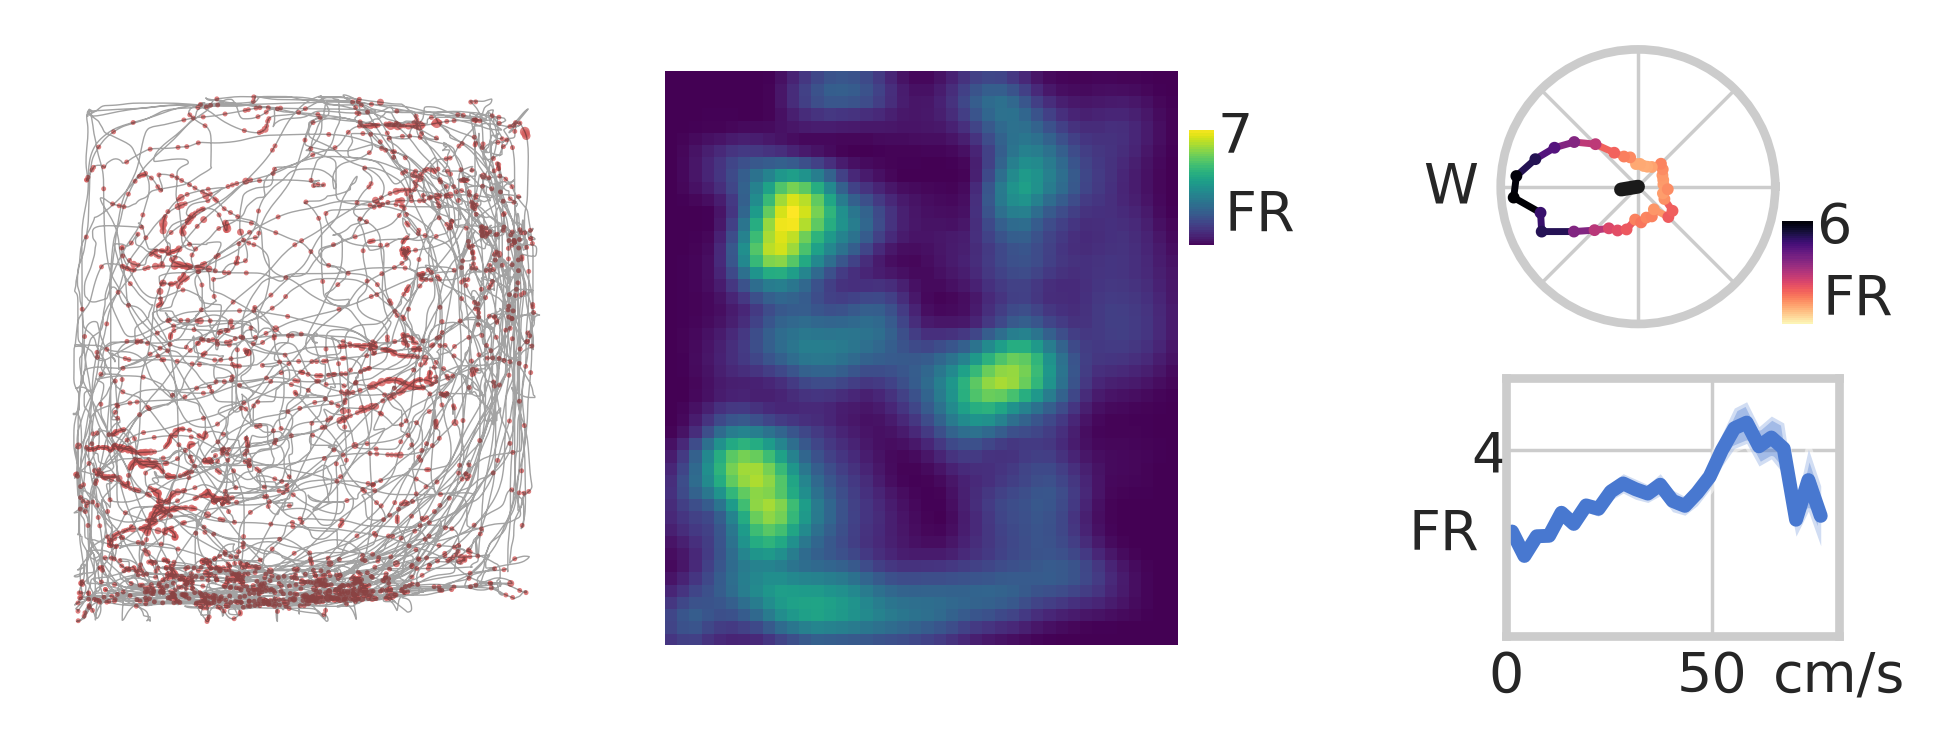

In [687]:

def plot_OF_example_unit_final(cl_name, track_data, spikes, fr, fr_map, figsize=None):
    
    
    dpi = 500
    label_fontsize = 10
    tick_fontsize=8
    def plot_xy_spks(x,y,spikes,ax):
        ax.plot(x,y,linewidth=0.2,color='k',alpha=0.4)
        xs = x[spikes>0]
        ys = y[spikes>0]
        ss = spikes[spikes>0]
        ax.scatter(xs,ys,s=ss*0.5, color='r', edgecolors=None, alpha=0.8, linewidth=0)
        ax.set_aspect('equal',adjustable='box')
        ax.set_axis_off()
        return ax

    def plot_fr_map(fr_map, ax, cmap='viridis'):
        vmin=0 
        vmax = fr_map.max()
        colors = plt.cm.get_cmap(cmap)(fr_map/vmax)

        ax = sns.heatmap(fr_map, xticklabels=[], yticklabels=[], cmap=cmap, 
                         vmin=0, vmax=vmax, square=True, cbar=False, ax=ax)

        ax.invert_yaxis()
        cax = getColBar(ax, fr_map.flatten(), cmap=cmap, cax_pos=[1.02,0,0.05,0.2])
        cax.set_yticklabels(['',int(vmax)], fontsize=tick_fontsize, ha='center')
        cax.set_ylabel('FR', rotation='horizontal', va='top', fontsize=tick_fontsize, labelpad=1)
        return ax, cax

    def plot_ang_fr(ang_bins,ang_fr, mean_ang, vec_len ,ax, cmap='magma_r', set_title=True):
        colors = plt.cm.get_cmap(cmap)(ang_fr/ang_fr.max())

        ax.scatter(ang_bins,ang_fr,s=0.5,color=colors,zorder=2)
        colorline( np.append(ang_bins,ang_bins[0]) ,np.append(ang_fr,ang_fr[0]),colors=np.append(colors,[colors[0]],axis=0), 
                  linewidth=1, ax=ax)

        ax.plot([0,mean_ang],[0,vec_len],color='k',linewidth=2, solid_capstyle='round')
        #ax.set_xticklabels(['','','','','W'], fontsize=tick_fontsize, ha='left')    
        ax.set_xticklabels([])
        
        vmax=np.max(ang_fr)
        ax.set_yticks([])
        ax.set_ylim([0,vmax*1.1])
        ax.text(np.pi, ang_fr.max()*1.5, 'W', fontsize=tick_fontsize, ha='center', va='center')
        if set_title:
            ax.set_title('HD Tunning', fontsize=label_fontsize)

        cax=getColBar(ax, ang_fr, cmap=cmap, cax_pos=[0.95,0,0.05,0.2])
        cax.set_yticklabels(['',int(vmax)], fontsize=tick_fontsize, ha='center')
        cax.set_ylabel('FR', rotation='horizontal', va='top', fontsize=tick_fontsize, labelpad=1)

        return ax, cax

    def plot_sp_fr(sp_bins, sp_fr_m, sp_fr_s, ax, set_title=True):
        
        ax.plot(sp_bins,sp_fr_m,linewidth=2)
        ax.fill_between(sp_bins, sp_fr_m - sp_fr_s, sp_fr_m + sp_fr_s, alpha=0.5)
        #ax.set_xlabel(' Speed [cm/s]')
        ax.set_ylim([np.nanmin(sp_fr_m-sp_fr_s)*0.9, np.nanmax(sp_fr_m+sp_fr_s)*1.1])
        
        #ax.yaxis.tick_right()
        vmax = np.max(sp_fr_m).astype(int)
        ax.set_yticks([0, vmax])
        ax.set_yticklabels(['', vmax], fontsize=tick_fontsize)
        ax.yaxis.set_tick_params(right=False) 
        yticklabels=ax.get_yticklabels() 
        for l in yticklabels:
            pos = l.get_position()
            l.set_position((pos[0]+0.2, pos[1]+0.2))
        ax.set_yticklabels(yticklabels)
        ax.set_ylabel("FR", fontsize=tick_fontsize, rotation=0, va='top')
        
        ax.set_xlim([0,81])
        ax.set_xticks([0, 50, 81])
        ax.set_xticklabels(['0', '50', 'cm/s'], fontsize=tick_fontsize, va='center')
        xticklabels=ax.get_xticklabels() 
        for l in xticklabels:
            pos = l.get_position()
            l.set_position((pos[0], pos[1]+0.1))
        ax.set_xticklabels(xticklabels)
        if set_title:
            ax.set_title('Speed Tunning', fontsize=tick_fontsize)
        return ax
    
    if figsize is None:
        f = plt.figure(constrained_layout=False, figsize=(4.5 , 2), dpi=dpi)
    else:
        f = plt.figure(constrained_layout=True, figsize=figsize)
        
    gs = f.add_gridspec(2,3)
    ax = [[]]*4
    ax[0] = f.add_subplot(gs[:, 0])
    ax[1] = f.add_subplot(gs[:, 1])
    ax[2] = f.add_subplot(gs[0, 2], projection='polar')
    ax[3] = f.add_subplot(gs[1, 2])

    x,y = track_data['x'],track_data['y']
    ax[0] = plot_xy_spks(x,y,spikes,ax[0])
    
    ax[1], cax = plot_fr_map(fr_map, ax[1])
    ap = cax.get_position()
    pos =[ap.x0,ap.y0+0.4, ap.width, ap.height]
    cax.set_position(pos)
     
    res = get_bin_ang_fr(track_data, fr)
    vec_len, mean_ang, ang_fr, ang_bin_centers = res['vec_len'], res['mean_ang'], res['ang_fr'], res['ang_bin_centers']
    ax[2], cax = plot_ang_fr(ang_bin_centers, ang_fr, mean_ang, vec_len,  ax[2], set_title=False)
    ap = cax.get_position()
    pos =[ap.x0+0.04,ap.y0, ap.width*1.8, ap.height*1.5]
    cax.set_position(pos)
    ap = ax[2].get_position()
    pos = [ap.x0+0.06, ap.y0, ap.width*0.8, ap.height*0.8]
    ax[2].set_position(pos)
    
    res = get_bin_sp_fr(track_data, fr)
    sp_bin_centers, sp_fr_m, sp_fr_s = res['sp_bin_centers'], res['sp_fr_m'], res['sp_fr_s']
    ax[3] = plot_sp_fr(sp_bin_centers, sp_fr_m, sp_fr_s, ax[3], set_title=False)

    ap = ax[3].get_position()
    pos = [ap.x0+0.1, ap.y0+0.1, ap.width*0.65, ap.height*0.75]
    ax[3].set_position(pos)
    
#     titles = ['Spike Traces', 'Rate Map', 'HD & Sp. Tunning']
#     for ii, t in enumerate(titles):
#         ax[ii].set_title(t, fontsize=label_fontsize)
    
#     axt = f.add_axes([0,0,0.02,1])
#     axt.text(-0.2,.25, cl_name, rotation=90)
#     axt.set_axis_off()
    return f, ax

idx = 2879
sns.set_style("whitegrid")
cl_name = metric_scores.loc[idx, 'cl_name']
f,ax = plot_OF_example_unit_final(cl_name, *load_cell(idx, metric_scores))
#ax[0].set_rasterized(True)
#ax[1].set_rasterized(True)
uuid = metric_scores.loc[idx, 'unit_id']
#f.savefig(fig5_path / f'OF_Metrics_{cl_name}.pdf',dpi=1200, bbox_inches='tight')
f.savefig(fig5_path / f'OF_Metrics_{uuid}.png',dpi=1200, bbox_inches='tight')

#f.savefig(fig5_path / f'OF_Metrics_{cl_name}.svg',dpi=300, bbox_inches='tight', pad_inches=0.2)

In [747]:
metric_scores[metric_scores.unit_id==1968]

unit_id subject       session  session_pct_cov  session_valid  \
9840     1968      Cl  Cl_OF_013119             0.89           True   
9855     1968      Cl  Cl_OF_013119             0.89           True   
9870     1968      Cl  Cl_OF_013119             0.89           True   
9885     1968      Cl  Cl_OF_013119             0.89           True   
9900     1968      Cl  Cl_OF_013119             0.89           True   

      session_unit_id unit_type  tt  tt_cl                       cl_name  \
9840                0      cell   2     19  Cl_OF_013119-tt2_d16.25_cl19   
9855                0      cell   2     19  Cl_OF_013119-tt2_d16.25_cl19   
9870                0      cell   2     19  Cl_OF_013119-tt2_d16.25_cl19   
9885                0      cell   2     19  Cl_OF_013119-tt2_d16.25_cl19   
9900                0      cell   2     19  Cl_OF_013119-tt2_d16.25_cl19   

     analysis_type     score  sig  
9840         speed -0.124626  1.0  
9855            hd  0.015179  0.0  
9870        border  0.446991  0.0  
9885          grid       NaN  0.0  
9900     stability  0.519118  1.0

In [1010]:
figsize=(1.5,1.5)
label_fontsize = 9
tick_fontsize=6
dpi=1200
def plot_OF2(track_data, spikes, fr, fr_map):
    
    def plot_fr_map(fr_map, ax, cmap='viridis'):
        vmin=0 
        vmax = fr_map.max()
        colors = plt.cm.get_cmap(cmap)(fr_map/vmax)

        ax = sns.heatmap(fr_map, xticklabels=[], yticklabels=[], cmap=cmap, 
                         vmin=0, vmax=vmax, square=True, cbar=False, ax=ax)

        ax.invert_yaxis()
        cax = getColBar(ax, np.array((vmin,vmax)), cmap=cmap, cax_pos=[1.02,0,0.05,0.2])
        cax.set_yticklabels(['',int(vmax)], fontsize=tick_fontsize, ha='center')
        yticklabels = cax.get_yticklabels()
        for l in yticklabels:
            pos = l.get_position()
            l.set_position((pos[0]+0.3, pos[1]))
        cax.set_yticklabels(yticklabels)
        #cax.set_ylabel('FR', rotation=0, va='top', ha='right', fontsize=tick_fontsize, labelpad=1)
        ax.text(fr_map.shape[1]*1.3, 0, 'FR', fontsize=tick_fontsize, ha='center', va='center')
        return ax, cax

    def plot_ang_fr(ang_bins,ang_fr, mean_ang, vec_len ,ax, cmap='magma_r', set_title=True):
        colors = plt.cm.get_cmap(cmap)(ang_fr/ang_fr.max())

        ax.scatter(ang_bins,ang_fr,s=0.4,color=colors,zorder=2)
        colorline( np.append(ang_bins,ang_bins[0]) ,np.append(ang_fr,ang_fr[0]),colors=np.append(colors,[colors[0]],axis=0), 
                  linewidth=0.8, ax=ax)

        ax.plot([0,mean_ang],[0,vec_len],color='k',linewidth=1.5, solid_capstyle='round')
        #ax.set_xticklabels(['','','','','W'], fontsize=tick_fontsize, ha='left')    
        ax.set_xticklabels([])
        
        vmax=np.max(ang_fr)
        ax.set_yticks([])
        ax.set_ylim([0,vmax*1.1])
        ax.text(0, ang_fr.max()*1.5, 'E', fontsize=tick_fontsize, ha='center', va='center')
        ax.text(-np.pi/4+0.1, ang_fr.max()*2, 'FR', fontsize=tick_fontsize, ha='center', va='center')
        if set_title:
            ax.set_title('HD Tunning', fontsize=label_fontsize)

        cax=getColBar(ax, ang_fr, cmap=cmap, cax_pos=[0.95,0,0.05,0.2])
        cax.set_yticklabels(['',int(vmax)], fontsize=tick_fontsize, ha='center')
        yticklabels = cax.get_yticklabels()
        for l in yticklabels:
            pos = l.get_position()
            l.set_position((pos[0]+0.3, pos[1]))
        #cax.set_ylabel('FR', rotation=0, fontsize=tick_fontsize, ha='right', va='top', labelpad=3)# **{'x':1290 , 'y':0})

        return ax, cax

    def plot_sp_fr(sp_bins, sp_fr_m, sp_fr_s, ax, set_title=True):
        
        ax.plot(sp_bins,sp_fr_m,linewidth=1)
        ax.fill_between(sp_bins, sp_fr_m - sp_fr_s, sp_fr_m + sp_fr_s, alpha=0.5)
        #ax.set_xlabel(' Speed [cm/s]')
        ax.set_ylim([np.nanmin(sp_fr_m-sp_fr_s)*0.9, np.nanmax(sp_fr_m+sp_fr_s)*1.1])
        
        #ax.yaxis.tick_right()
        vmax = np.max(sp_fr_m).astype(int)
        ax.set_yticks([0, vmax])
        ax.set_yticklabels(['', vmax], fontsize=tick_fontsize)
        ax.yaxis.tick_right()
        ax.yaxis.set_tick_params(right=False) 
        yticklabels=ax.get_yticklabels() 
        for l in yticklabels:
            pos = l.get_position()
            l.set_position((pos[0]-0.3, pos[1]))
        ax.set_yticklabels(yticklabels)
        #ax.set_ylabel("FR",  fontsize=tick_fontsize, rotation=0, ha='right', va='top', labelpad=0, y=0.2)
        
        ax.set_xlim([0,81])
        ax.set_xticks([0,25,50, 75])
        ax.set_xticklabels(['0', '','', '75'], fontsize=tick_fontsize)
        xticklabels=ax.get_xticklabels() 
        for l in xticklabels:
            pos = l.get_position()
            l.set_position((pos[0], pos[1]+0.4))
        ax.set_xticklabels(xticklabels)
        if set_title:
            ax.set_title('Speed Tunning', fontsize=tick_fontsize)
        
        ax.text(100, vmax*0.1, 'FR', fontsize=tick_fontsize, ha='center', va='center')
        
        return ax
    
    f = plt.figure(figsize=figsize, dpi=dpi//2)
    gs = f.add_gridspec(3,1)
    ax = [[]]*3
    ax[0] = f.add_subplot(gs[0])
    ax[1] = f.add_subplot(gs[1], projection='polar')#, position=[0.42, 0.42, 0.25, 0.25])
    ax[2] = f.add_subplot(gs[2]) #position=[0.42, 0.1, 0.25, 0.25])
    
    ax[0], cax = plot_fr_map(fr_map, ax[0])
    ap = cax.get_position()
    pos =[ap.x0+0.005, ap.y0, ap.width*1.5, ap.height*1.5]
    cax.set_position(pos)
    
    res = get_bin_ang_fr(track_data, fr)
    vec_len, mean_ang, ang_fr, ang_bin_centers = res['vec_len'], res['mean_ang'], res['ang_fr'], res['ang_bin_centers']
    ax[1], cax = plot_ang_fr(ang_bin_centers, ang_fr, mean_ang, vec_len,  ax[1], set_title=False)
    
    ap = cax.get_position()
    pos =[ap.x0+0.005, ap.y0, ap.width*1.5, ap.height*1.3]
    cax.set_position(pos)
    
    ap = ax[1].get_position()
    pos = [ap.x0+0.04, ap.y0, ap.width, ap.height]
    #print(pos)
    #ax[1].set_position(pos)
    
    
    res = get_bin_sp_fr(track_data, fr)
    sp_bin_centers, sp_fr_m, sp_fr_s = res['sp_bin_centers'], res['sp_fr_m'], res['sp_fr_s']
    ax[2] = plot_sp_fr(sp_bin_centers, sp_fr_m, sp_fr_s, ax[2], set_title=False)

    ap = ax[2].get_position()
    pos = [ap.x0+0.28, ap.y0+0.03, ap.width*0.29, ap.height*0.75]
    ax[2].set_position(pos)
    ax[2].set_xlabel('cm/s', fontsize=tick_fontsize, va='bottom', **{'x':0.5, 'y':0.7})     
    ax[2].yaxis.set_label_position("right")
    
    
    return f, ax

#idx = 9846
# idx = 9846
# uuid = metric_scores.loc[idx, 'unit_id']
# #sns.set_style("whitegrid", {'grid.linewidth': 0.5})
# sns.set_context("notebook", font_scale=1, rc={'grid.linewidth': 0.5})
# f,ax = plot_OF2(*load_cell(idx, metric_scores))
#f.savefig(fig5_path / f'OF_Metrics_short_{uuid}.png',dpi=dpi, bbox_inches='tight')
for uuid in [113, 86, 569]:#[312, 569, 60,966,508,890,9846,1468]:
    sns.set_context("notebook", font_scale=1, rc={'grid.linewidth': 0.5})
    #f,ax = plot_OF2(*load_cell2(uuid, metric_scores))
    #f.savefig(fig5_path / f'OF_Metrics_short_{uuid}.png',dpi=dpi, bbox_inches='tight')


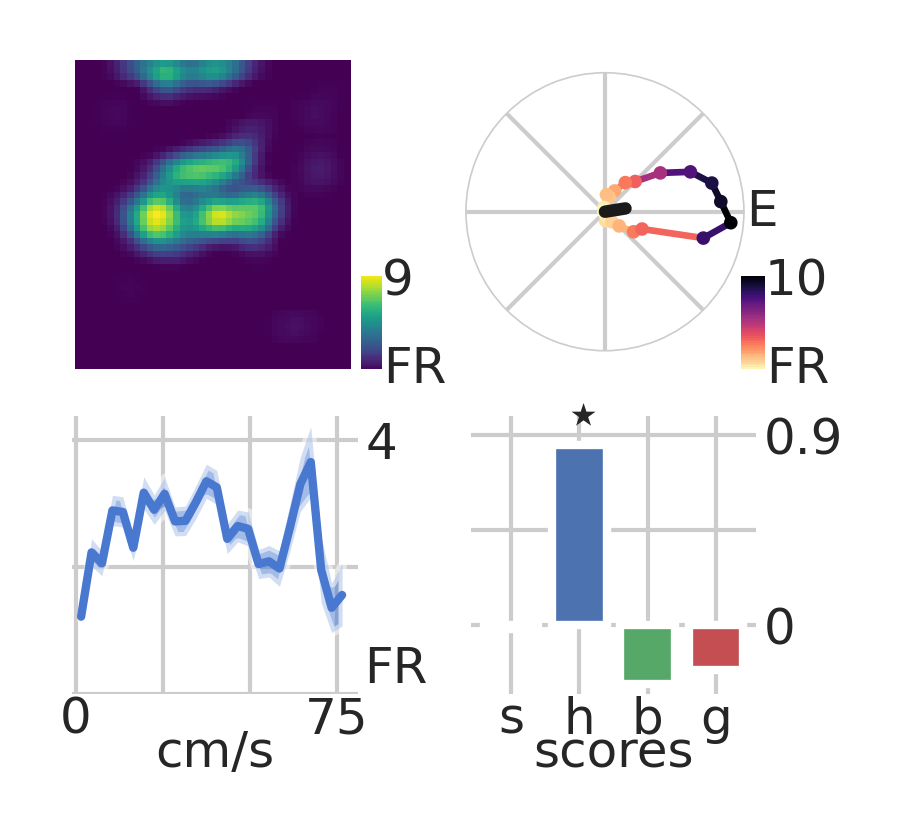

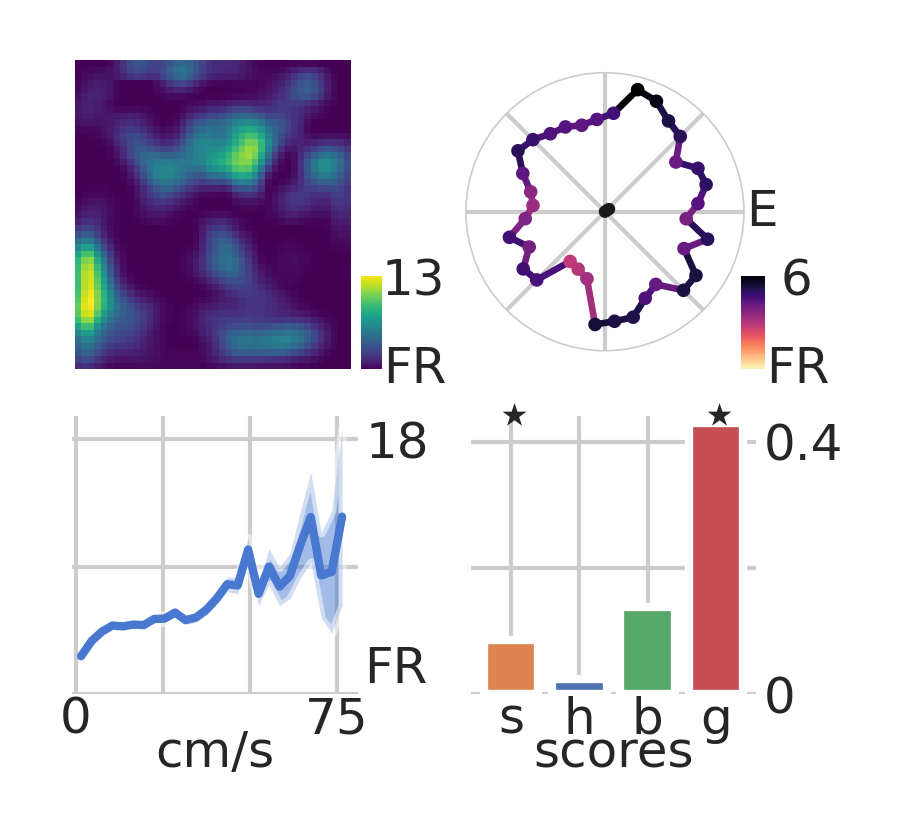

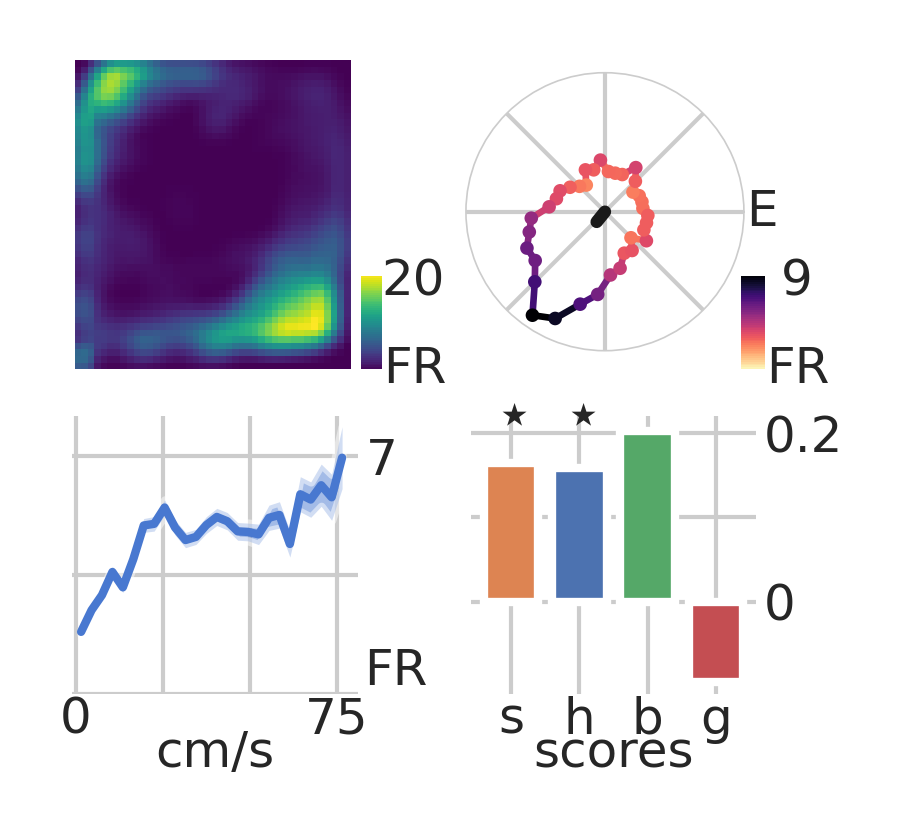

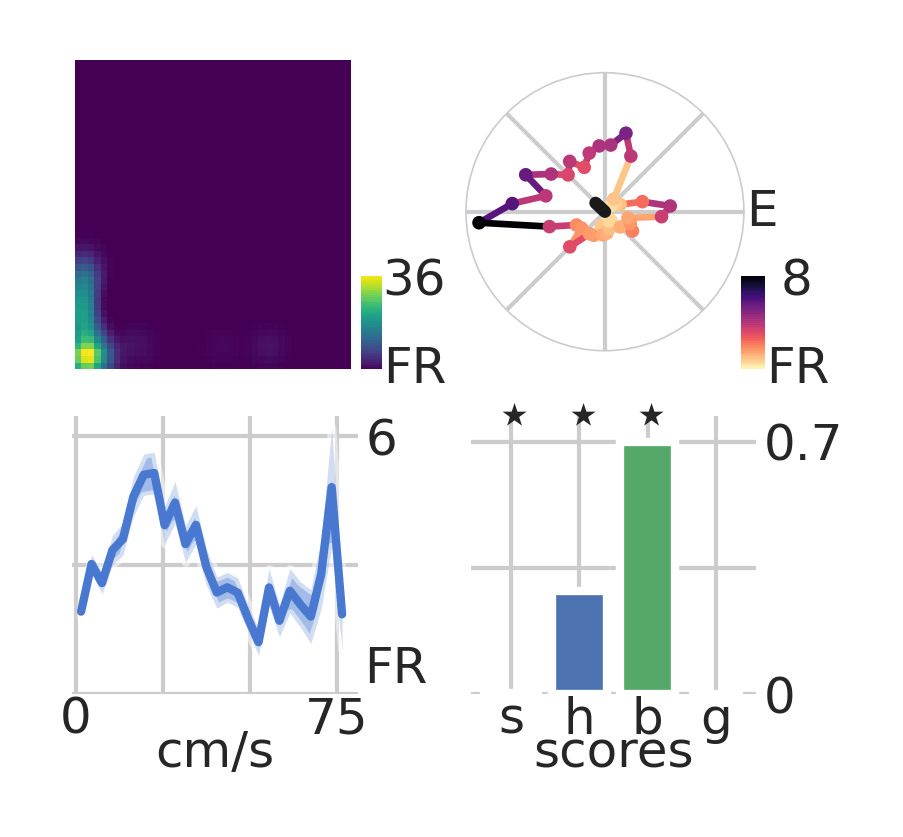

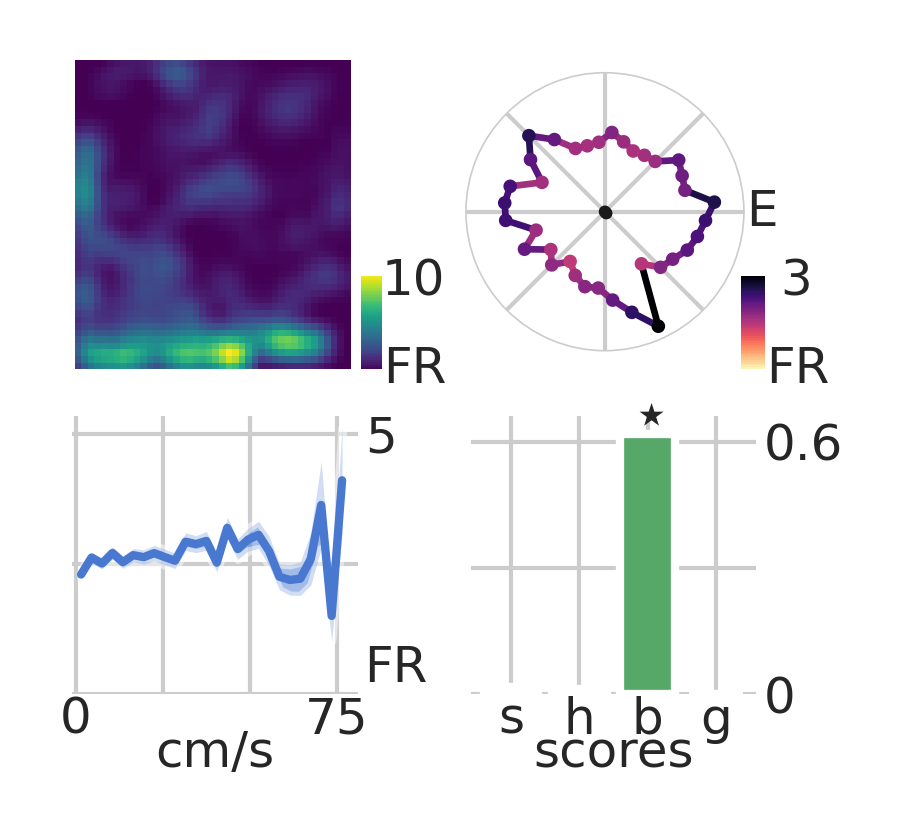

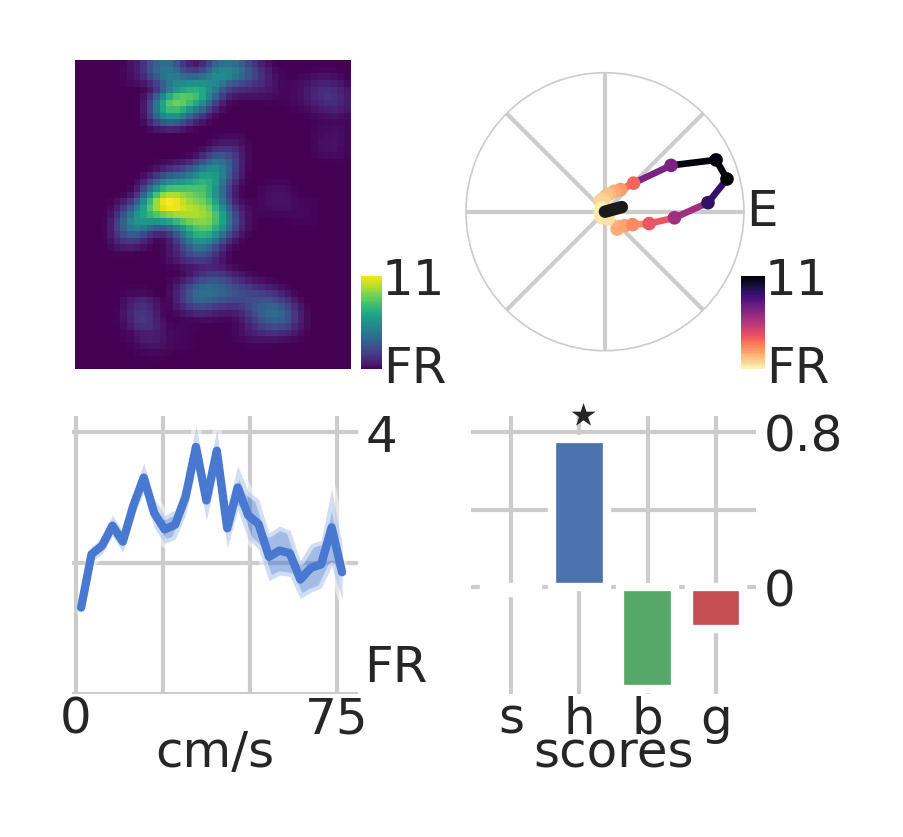

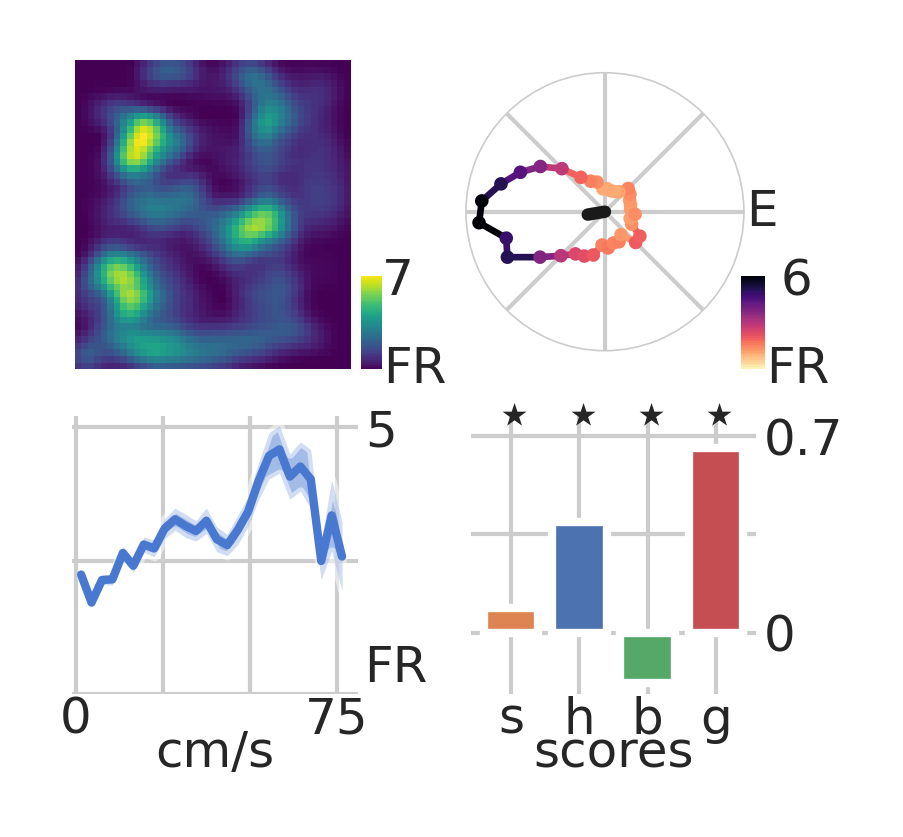

In [1013]:
figsize=(1.5,1.5)
label_fontsize = 9
tick_fontsize=6
dpi=1200
sns.set_style("whitegrid")

def plot_OF_example_scores(uuid):
    track_data, spikes, fr, fr_map = load_cell2(uuid, metric_scores)
    def plot_fr_map(fr_map, ax, cmap='viridis'):
        vmin=0 
        vmax = fr_map.max()
        colors = plt.cm.get_cmap(cmap)(fr_map/vmax)

        ax = sns.heatmap(fr_map, xticklabels=[], yticklabels=[], cmap=cmap, 
                         vmin=0, vmax=vmax, square=True, cbar=False, ax=ax)

        ax.invert_yaxis()
        
        cax = getColBar(ax, np.array((vmin,vmax)), cmap=cmap, cax_pos=[1.02,0,0.05,0.2])
        cax.set_yticklabels(['',int(vmax)], fontsize=tick_fontsize, ha='left')
        yticklabels = cax.get_yticklabels()
        for l in yticklabels:
            pos = l.get_position()
            l.set_position((pos[0]-1.2, pos[1]))
        cax.set_yticklabels(yticklabels)
        
        cax.text(1.05, 0, 'FR', fontsize=tick_fontsize, ha='left', va='center',  transform=cax.transAxes)
        
        return ax, cax

    def plot_ang_fr(ang_bins,ang_fr, mean_ang, vec_len ,ax, cmap='magma_r'):
        colors = plt.cm.get_cmap(cmap)(ang_fr/ang_fr.max())

        ax.scatter(ang_bins,ang_fr,s=0.4,color=colors,zorder=2)
        colorline( np.append(ang_bins,ang_bins[0]) ,np.append(ang_fr,ang_fr[0]),colors=np.append(colors,[colors[0]],axis=0), 
                  linewidth=0.8, ax=ax)

        ax.plot([0,mean_ang],[0,vec_len],color='k',linewidth=1.5, solid_capstyle='round')
        ax.set_xticklabels([])
        
        vmax=np.max(ang_fr)
        ax.set_yticks([])
        ax.set_ylim([0,vmax*1.1])
        ax.text(0, ang_fr.max()*1.12, 'E', fontsize=tick_fontsize, ha='left', va='center')
        #ax.text(-np.pi/4+0.1, ang_fr.max()*1.85, 'FR', fontsize=tick_fontsize, ha='center', va='center')

        cax=getColBar(ax, ang_fr, cmap=cmap, cax_pos=[0.95,0,0.05,0.2])
        cax.set_yticklabels(['',int(vmax)], fontsize=tick_fontsize, ha='center')
        yticklabels = cax.get_yticklabels()
        for l in yticklabels:
            pos = l.get_position()
            l.set_position((pos[0]+0.3, pos[1]))
            
        cax.text(1.05,0, 'FR', fontsize=tick_fontsize, ha='left', va='center', transform=cax.transAxes)
        
        for d in ['polar', 'start', 'end', 'inner']: 
            ax.spines[d].set_linewidth(0.2)
        return ax, cax

    def plot_sp_fr(sp_bins, sp_fr_m, sp_fr_s, ax):
        
        ax.plot(sp_bins,sp_fr_m,linewidth=1)
        ax.fill_between(sp_bins, sp_fr_m - sp_fr_s, sp_fr_m + sp_fr_s, alpha=0.5)
        
        vmax = np.round(np.max(sp_fr_m+sp_fr_s),1).astype(int)
        vmin = np.round(np.min(sp_fr_m-sp_fr_s),1)
        
        #ylims = np.array( (vmin-np.abs(vmin)*0.1, vmax+np.abs(vmax)*0.1) )
        ylims = np.array( np.min((0,(vmin-np.abs(vmin)*0.1))), vmax+np.abs(vmax)*0.1) 
        ax.set_ylim(ylims)
        
        ax.set_yticks([0, vmax/2, vmax])
        ax.set_yticklabels(['', '', vmax], fontsize=tick_fontsize, ha='left')
        ax.yaxis.tick_right()
        ax.yaxis.set_tick_params(right=False) 
        yticklabels=ax.get_yticklabels() 
        for l in yticklabels:
            pos = l.get_position()
            l.set_position((pos[0]-0.25, pos[1]))
        ax.set_yticklabels(yticklabels)
        
        ax.set_xlim([-1,81])
        ax.set_xticks([0,25,50, 75])
        ax.set_xticklabels(['0', '','', '75'], va='top', fontsize=tick_fontsize)
        xticklabels=ax.get_xticklabels() 
        for l in xticklabels:
            pos = l.get_position()
            l.set_position((pos[0], pos[1]+0.28))
        ax.set_xticklabels(xticklabels)
        
        for d in ['right', 'top', 'left', 'bottom']: 
            #ax.spines[d].set_linewidth(0.2)
            ax.spines[d].set_visible(False)
            
        ax.text(92, vmax*0.1, 'FR', fontsize=tick_fontsize, ha='center', va='center')
        ax.set_xlabel('cm/s', fontsize=tick_fontsize, va='bottom', **{'x':0.5, 'y':0})     
        ax.yaxis.set_label_position("right")
        return ax
    
    def plot_scores(ax):
        a = metric_scores.loc[metric_scores.unit_id==uuid, ['analysis_type', 'score', 'sig']]
        a = a[a.analysis_type.isin(['speed', 'hd', 'border', 'grid'])]
        a = a.fillna(0)

        c =list(map(lambda k: type_color[k], a.analysis_type))
        
        ax.bar(x=a.analysis_type, height=a.score,color=c)
        vmin, vmax = a.score.min(), a.score.max()
        vmax = np.around(vmax,1)
        vmin = np.around(vmin,1)
        
        ylims = np.array( (vmin-np.abs(vmin)*0.1, vmax+np.abs(vmax)*0.1) )
        ax.set_ylim(ylims)
        ylim_range = ylims[1]-ylims[0]
        star_loc = ylims[1] + 0.1*ylim_range
        for ii in np.arange(4):
            if a.iloc[ii].sig:
                ax.text(ii, ylims[1], r'$\star$',fontsize=tick_fontsize*1.25, va='center', ha='center')
            
        ax.yaxis.tick_right()
        ax.yaxis.set_tick_params(right=False) 
        
        ax.set_yticks([0, vmax/2, vmax])
        ax.set_yticklabels([0, '', np.around(vmax,1)], fontsize=tick_fontsize, ha='left')
        yticklabels=ax.get_yticklabels() 
        for l in yticklabels:
            pos = l.get_position()
            l.set_position((pos[0]-0.25, pos[1]))
        ax.set_yticklabels(yticklabels)
                
        l = ['s', 'h', 'b', 'g']
        ax.set_xticklabels(l, va='top', fontsize=tick_fontsize)
        xticklabels=ax.get_xticklabels() 
        for l in xticklabels:
            pos = l.get_position()
            l.set_position((pos[0], pos[1]+0.28))
        ax.set_xticklabels(xticklabels)
        ax.set_xlabel('scores', fontsize=tick_fontsize, va='bottom', **{'x':0.5, 'y':0})     

        for d in ['right', 'top', 'left', 'bottom']:
            ax.spines[d].set_visible(False)
    
    f = plt.figure(figsize=figsize, dpi=dpi//2)
    gs = f.add_gridspec(2,2)
    ax = [[]]*4
    ax[0] = f.add_subplot(gs[0])
    ax[1] = f.add_subplot(gs[1], projection='polar')#, position=[0.42, 0.42, 0.25, 0.25])
    ax[2] = f.add_subplot(gs[2]) #position=[0.42, 0.1, 0.25, 0.25])
    ax[3] = f.add_subplot(gs[3]) #position=[0.42, 0.1, 0.25, 0.25])
    
    ax[0], cax = plot_fr_map(fr_map, ax[0])
    ap = cax.get_position()
    pos =[ap.x0+0.005, ap.y0, ap.width*1.5, ap.height*1.5]
    cax.set_position(pos)
    
    res = get_bin_ang_fr(track_data, fr)
    vec_len, mean_ang, ang_fr, ang_bin_centers = res['vec_len'], res['mean_ang'], res['ang_fr'], res['ang_bin_centers']
    ax[1], cax = plot_ang_fr(ang_bin_centers, ang_fr, mean_ang, vec_len,  ax[1])
    ap = ax[1].get_position()
    pos =[ap.x0+0.03, ap.y0+0.02, ap.width*0.9, ap.height*0.9]
    ax[1].set_position(pos)
    
    ap = cax.get_position()
    pos =[ap.x0+0.01, ap.y0, ap.width*1.5, ap.height*1.5]
    cax.set_position(pos)
    
    
    res = get_bin_sp_fr(track_data, fr)
    sp_bin_centers, sp_fr_m, sp_fr_s = res['sp_bin_centers'], res['sp_fr_m'], res['sp_fr_s']
    ax[2] = plot_sp_fr(sp_bin_centers, sp_fr_m, sp_fr_s, ax[2])

    ap = ax[2].get_position()
    pos = [ap.x0+0.02, ap.y0+0.05, ap.width*0.9, ap.height*0.9]
    ax[2].set_position(pos)

    plot_scores(ax[3])
    ap = ax[3].get_position()
    pos = [ap.x0+0.04, ap.y0+0.05, ap.width*0.9, ap.height*0.9]
    ax[3].set_position(pos)
    
    return f, ax

for uuid in [293, 890, 86, 60, 966, 355, 569]:
    f,ax = plot_OF_example_scores(uuid)
    f.savefig(fig5_path / f'OF_Metrics_short_{uuid}.png',dpi=dpi, bbox_inches='tight')

In [978]:
a = metric_scores.loc[metric_scores.unit_id==748, ['analysis_type', 'score', 'sig']]
a = a[a.analysis_type.isin(['speed', 'hd', 'border', 'grid'])]
a = a.fillna(0)
a

analysis_type     score  sig
3664         speed  0.032440  1.0
3684            hd  0.132281  1.0
3704        border -0.215158  0.0
3724          grid  0.276145  0.0

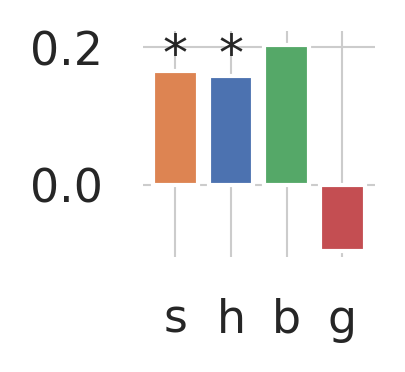

In [818]:

a = metric_scores.loc[metric_scores.unit_id==uuid, ['analysis_type', 'score', 'sig']]
a=a.iloc[:4]

c =list(map(lambda k: type_color[k], a.analysis_type))
f,ax=plt.subplots(figsize=(1,1),dpi=300)
ax.bar(x=a.analysis_type, height=a.score,color=c)
ylims = np.array( (a.score.min(), a.score.max()))*1.1
ax.set_ylim(ylims)
ylim_range = ylims[1]-ylims[0]
star_loc = ylims[1] + 0.1*ylim_range
for ii in np.arange(4):
    if a.iloc[ii].sig:
        ax.text(ii, ylims[1], '*',fontsize=tick_fontsize*2, va='top', ha='center')

l = ['s', 'h', 'b', 'g']
ax.set_xticklabels(l)
for d in ['right', 'top', 'left', 'bottom']:
    ax.spines[d].set_visible(False)
    #[i.set_linewidth(0.1) for i in ax.spines.itervalues()]
        

## Plot a few example rasters

In [19]:
model = 'pos'
thr = 0.05
model_metric='r2'
split='test'
unit_type='cell'
sub_model_table = model_filter_units(model, thr, model_metric, split, unit_type=unit_type)
sub_model_table

unit_id subject       session  session_unit_id unit_type  \
24128      389      Li  Li_OF_062018               10      cell   
28558      462      Li  Li_OF_062718                9      cell   
38978      641      Li  Li_OF_080218                9      cell   
26808      438      Li  Li_OF_062618                8      cell   
28568      463      Li  Li_OF_062718               10      cell   
...        ...     ...           ...              ...       ...   
60598     1007      Ne  NE_OF_071118                1      cell   
37538      613      Li  Li_OF_080118                1      cell   
99178     1640      Cl  Cl_OF_121818                1      cell   
2108        24      Li  Li_OF_052918               10      cell   
22238      355      Li  Li_OF_061818                3      cell   

       session_pct_cov  session_valid  tt  tt_cl model split metric     value  \
24128             0.98           True  10      0   pos  test     r2  0.548537   
28558             0.93           True  10      0   pos  test     r2  0.535120   
38978             0.97           True  10     13   pos  test     r2  0.518426   
26808             0.95           True  10      0   pos  test     r2  0.490407   
28568             0.93           True  10      7   pos  test     r2  0.473734   
...                ...            ...  ..    ...   ...   ...    ...       ...   
60598             0.94           True  11      9   pos  test     r2  0.051643   
37538             0.97           True   8     14   pos  test     r2  0.051557   
99178             0.93           True  10      5   pos  test     r2  0.051337   
2108              0.97           True   8     20   pos  test     r2  0.051168   
22238             0.94           True   8      0   pos  test     r2  0.051001   

                             cl_name  
24128   Li_OF_062018-tt10_d18.25_cl0  
28558    Li_OF_062718-tt10_d18.5_cl0  
38978  Li_OF_080218-tt10_d19.75_cl13  
26808   Li_OF_062618-tt10_d18.25_cl0  
28568    Li_OF_062718-tt10_d18.5_cl7  
...                              ...  
60598    NE_OF_071118-tt11_d14.5_cl9  
37538   Li_OF_080118-tt8_d18.25_cl14  
99178    Cl_OF_121818-tt10_d13.0_cl5  
2108    Li_OF_052918-tt8_d16.25_cl20  
22238    Li_OF_061818-tt8_d16.75_cl0  

[221 rows x 14 columns]

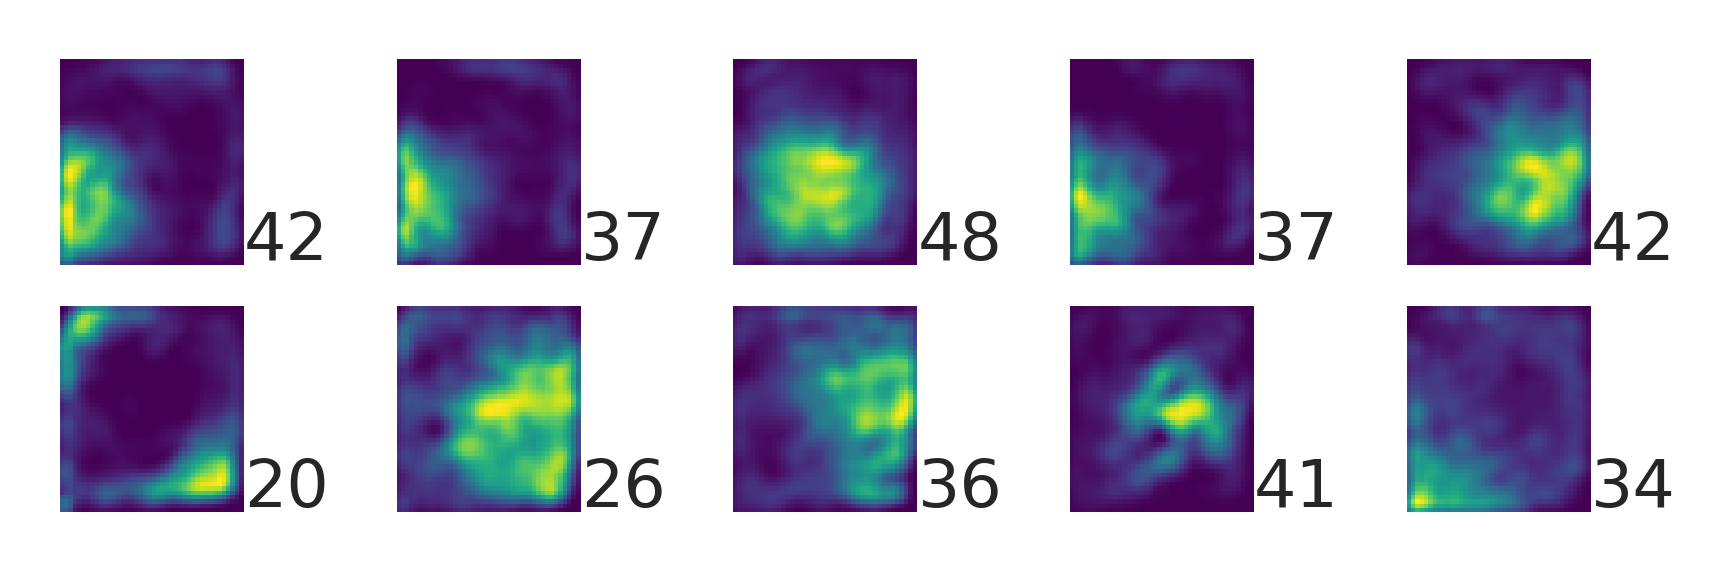

In [20]:
fontsize=8
def plot_fr_map2(track_data, spikes, fr, fr_map, cl_name=None, ax=None, cbar=False, max_txt=True, cmap='viridis'):
    if ax is None:
        f,ax = plt.subplots(figsize=(4,4))
    else:
        f = ax.figure
    
    vmin, vmax = 0, fr_map.max()
    colors = plt.cm.get_cmap(cmap)(fr_map/vmax)

    ax = sns.heatmap(fr_map, xticklabels=[], yticklabels=[], cmap=cmap, 
                     vmin=0, vmax=vmax, square=True, cbar=False, ax=ax)

    ax.invert_yaxis()
    #ax.set_title('FR Map', fontsize=label_fontsize)

    if cbar:
        cax = getColBar(ax, fr_map.flatten(), cmap=cmap, cax_pos=[1.02,0,0.05,0.2])
        cax.set_ylabel(' fr', rotation='horizontal', va='center', ha='right', fontsize=label_fontsize)

    if cl_name is not None:
        pos = ax.get_position()
        axt = f.add_axes([pos.x0-0.1,pos.y0,0.02,pos.height])
        axt.text(0,.1, cl_name, rotation=90)
        axt.set_axis_off()
        
    if max_txt:
        pos = ax.get_position()
        axt = f.add_axes([pos.x0+pos.width, pos.y0, 0.01,0.1])
        axt.text(0,.1, int(vmax), fontsize=fontsize)
        axt.set_axis_off()
        
    return f, ax

f = plt.figure(figsize=(3.5,1), dpi=600)
n_rows = 2
n_cols = 5
gs = f.add_gridspec(n_rows,n_cols)
ax = np.zeros((n_rows,n_cols), dtype=object)
cnt=0
for ii in range(n_rows):
    for jj in range(n_cols):
        ax[ii, jj] = f.add_subplot(gs[ii,jj])
        plot_fr_map2(*load_cell(sub_model_table.index[cnt], sub_model_table),ax=ax[ii,jj])
        #ax[ii,jj].set_rasterized(True)
        cnt+=1

In [1319]:
#f.savefig(fig5_path / f'OF_Rasters_thr-{model}.png',dpi=300, bbox_inches='tight', pad_inches=0.2)
#f.savefig(fig5_path / f'OF_Rasters_thr-{model}.pdf',dpi=300, bbox_inches='tight', pad_inches=0.2)
f.savefig(fig5_path / f'OF_Rasters_thr-{model}.pdf',dpi=600, bbox_inches='tight')

In [ ]:
def plot_OF3()

## Unit Metric Sig. Overlap

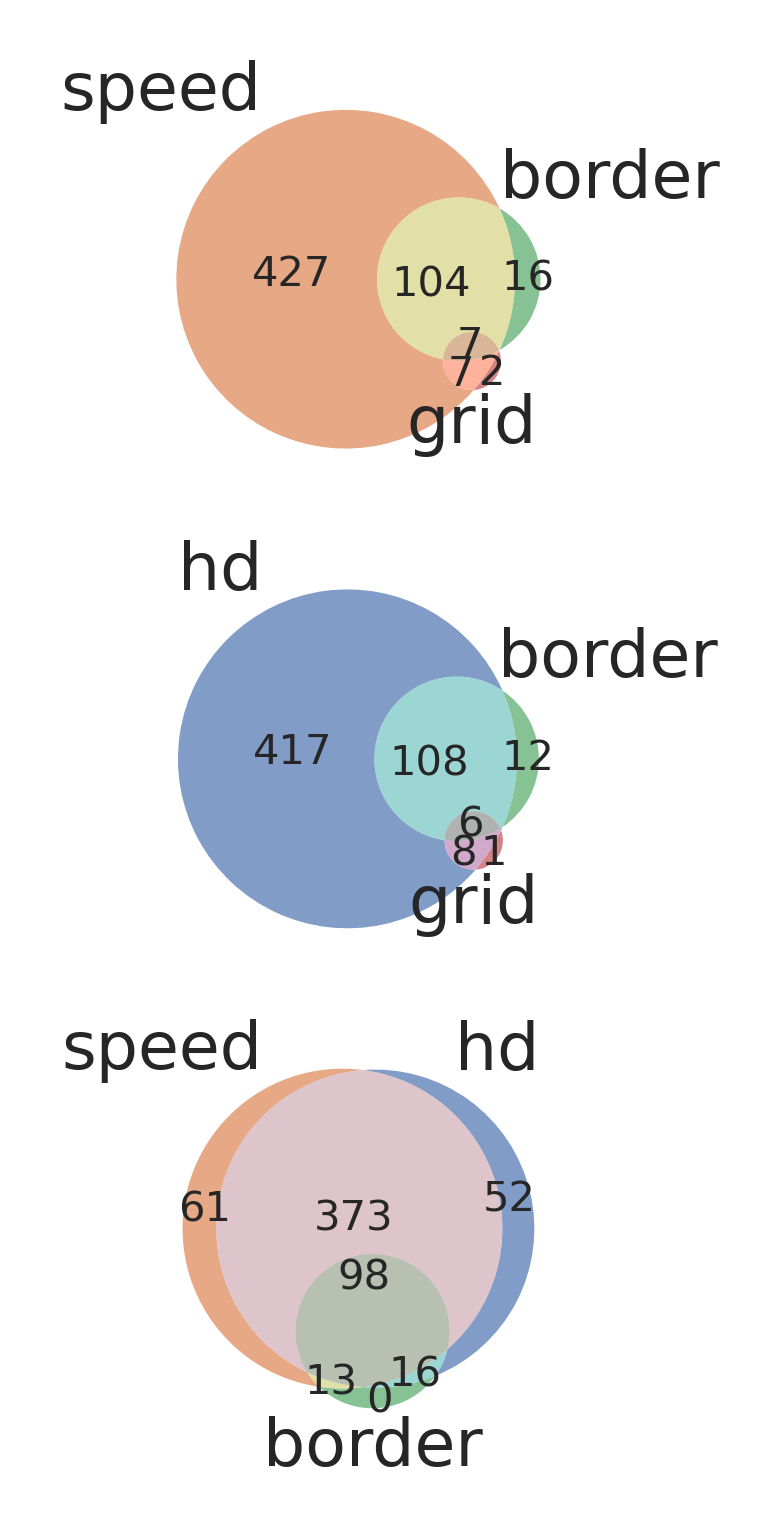

In [426]:
set_fontsize=5
set_labels_fontsize=8
dpi = 1200
for unit_type in ['cell']:#['cell', 'mua']:
    set_counts = {}
    for analysis in analyses:
        unit_ids = set(metric_scores[(metric_scores['analysis_type']==analysis) & 
                                     (metric_scores['unit_type']==unit_type) & 
                                     (metric_scores['sig']==1) & 
                                     (metric_scores['session_valid'])].cl_name)
        set_counts[analysis] = unit_ids

    f,ax = plt.subplots(3,1, figsize=(1,3), dpi=600)
    sets = [['speed', 'border', 'grid'], ['hd', 'border', 'grid'], ['speed', 'hd', 'border']]
    type_color = {'hd': analyses_colors[0],
                  'speed': analyses_colors[1],
                  'border': analyses_colors[2],
                  'grid': analyses_colors[3]}

    for ii in range(3):
        set_lists = [set_counts[jj] for jj in sets[ii]]
        set_colors = [type_color[analysis] for analysis in sets[ii]]
        out = venn3(set_lists, set_labels=sets[ii], ax=ax[ii], alpha=0.7,set_colors=set_colors)
        #out = venn3(set_lists, set_labels=['']*3, ax=ax[ii], alpha=0.7,set_colors=set_colors)
        for text in out.set_labels:
            text.set_fontsize(set_labels_fontsize)
        for x in range(len(out.subset_labels)):
            if out.subset_labels[x] is not None:
                out.subset_labels[x].set_fontsize(set_fontsize)

    # store
    #f.savefig(fig5_path/(f'Venn_{unit_type}_Counts2.pdf'), bbox_inches='tight', dpi=600)
    f.savefig(fig5_path/(f'Venn_{unit_type}_Counts2.png'), bbox_inches='tight', dpi=dpi)

['#DD8452', '#4C72B0', '#55A868']

## Units Metrics 

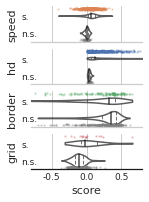

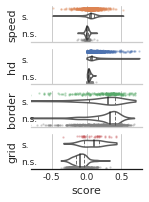

In [22]:
fontsize=11
tick_fontsize=9

for unit_type in ['cell', 'mua']:

    analyses = ['speed', 'hd', 'border', 'grid']
    f, ax = plt.subplots(4,1, figsize=(2,3))
    gs = f.add_gridspec(n_rows,n_cols,wspace=0.5)

    
    sns.set_style('whitegrid')
    for ii, analysis in enumerate(analyses):
        data_subset = metric_scores[ (metric_scores['unit_type']==unit_type) & 
                                        (metric_scores['analysis_type']==analysis) & 
                                        (metric_scores['session_valid']) ]
        data_subset = data_subset.astype({'sig': 'bool'})        
        data_subset = data_subset.astype({'sig': 'str'})

        sns.violinplot(data=data_subset, x='score', y='sig', order=['True', 'False'], color='white', cut=0, inner='quartile', linecolor='0.1', ax=ax[ii]) 
#         sns.violinplot(data=data_subset, x='score', hue='sig', order=['True', 'False'], split='True', scale='count', color='white', cut=0, inner='quartile', linecolor='0.1', ax=ax[ii]) 
        
        for l in ax[ii].lines:
            l.set_linestyle('--')
            l.set_linewidth(1)
            l.set_color('0.3')
            l.set_alpha(0.8)
        for l in ax[ii].lines[1::3]:
            l.set_linestyle('-')
            l.set_linewidth(1.5)
            l.set_color('0.1')
            l.set_alpha(0.8)
        for c in ax[ii].collections:
            c.set_edgecolor('0.2')
            c.set_alpha(0.8)
        
            
        sig_points = data_subset.sig=='True'
        ax[ii].scatter(x=data_subset['score'][sig_points], y=-0.4 + 0.1*(np.random.rand(sig_points.sum())-0.5), s=2, color=type_color[analysis], alpha=0.25)
        
        sig_points = data_subset.sig=='False'
        ax[ii].scatter(x=data_subset['score'][sig_points], y=1.4 + 0.05*(np.random.rand(sig_points.sum())-0.5), s=2, color='grey', alpha=0.25)


#         data_subset_sig = metric_scores[ (metric_scores['unit_type']==unit_type) & 
#                                         (metric_scores['analysis_type']==analysis) & 
#                                         (metric_scores['sig']) &
#                                         (metric_scores['session_valid']) ]

#         sns.violinplot(data=data_subset_sig, x='score', color='white', cut=0, ax=ax[ii],  inner='quartile')  
#         #sns.boxplot(data=data_subset_sig, x='score', color='white', whis=100, ax=ax[ii])
#         sns.stripplot(data=data_subset_sig, x='score', color=type_color[analysis], alpha=0.5, ax=ax[ii])

#         data_subset = metric_scores[ (metric_scores['unit_type']==unit_type) & 
#                                         (metric_scores['analysis_type']==analysis) &
#                                         (metric_scores['session_valid']) ]

#         sns.stripplot(data=data_subset, x='score', color='grey', alpha=0.1, jitter=0.2, ax=ax[ii])
        ax[ii].set_xlabel('')
        ax[ii].set_xlim([-0.8,0.8])
        if ii==3:
            xticks = ax[ii].get_xticks() 
            ax[ii].set_xticklabels(np.around(xticks,1), fontsize=tick_fontsize)
        else:
            ax[ii].set_xticklabels([])
    
        ax[ii].set_ylabel(analysis, fontsize=fontsize)
        for pos in ['right', 'top', 'left']:
            ax[ii].spines[pos].set_visible(False)
        ax[ii].set_xlabel('')
            
        xticklabels=ax[ii].get_xticklabels() 
        for l in xticklabels:
            pos = l.get_position()
            l.set_position((pos[0], pos[1]+0.2))
        ax[ii].set_xticklabels(xticklabels, fontsize=tick_fontsize)
        
        ax[ii].set_yticklabels(['s.', 'n.s.'], fontsize=tick_fontsize, ha='left')
        #ax[ii].set_frame_on(False)
        #ax[ii].get_xaxis().tick_bottom()
    ax[3].set_xlabel('score', fontsize=fontsize)
    ax[3].spines['bottom'].set_color('k')

    f.savefig(fig5_path/(f'MetricsScores_{unit_type}.pdf'), bbox_inches='tight')
    f.savefig(fig5_path/(f'MetricsScores_{unit_type}.png'), bbox_inches='tight')

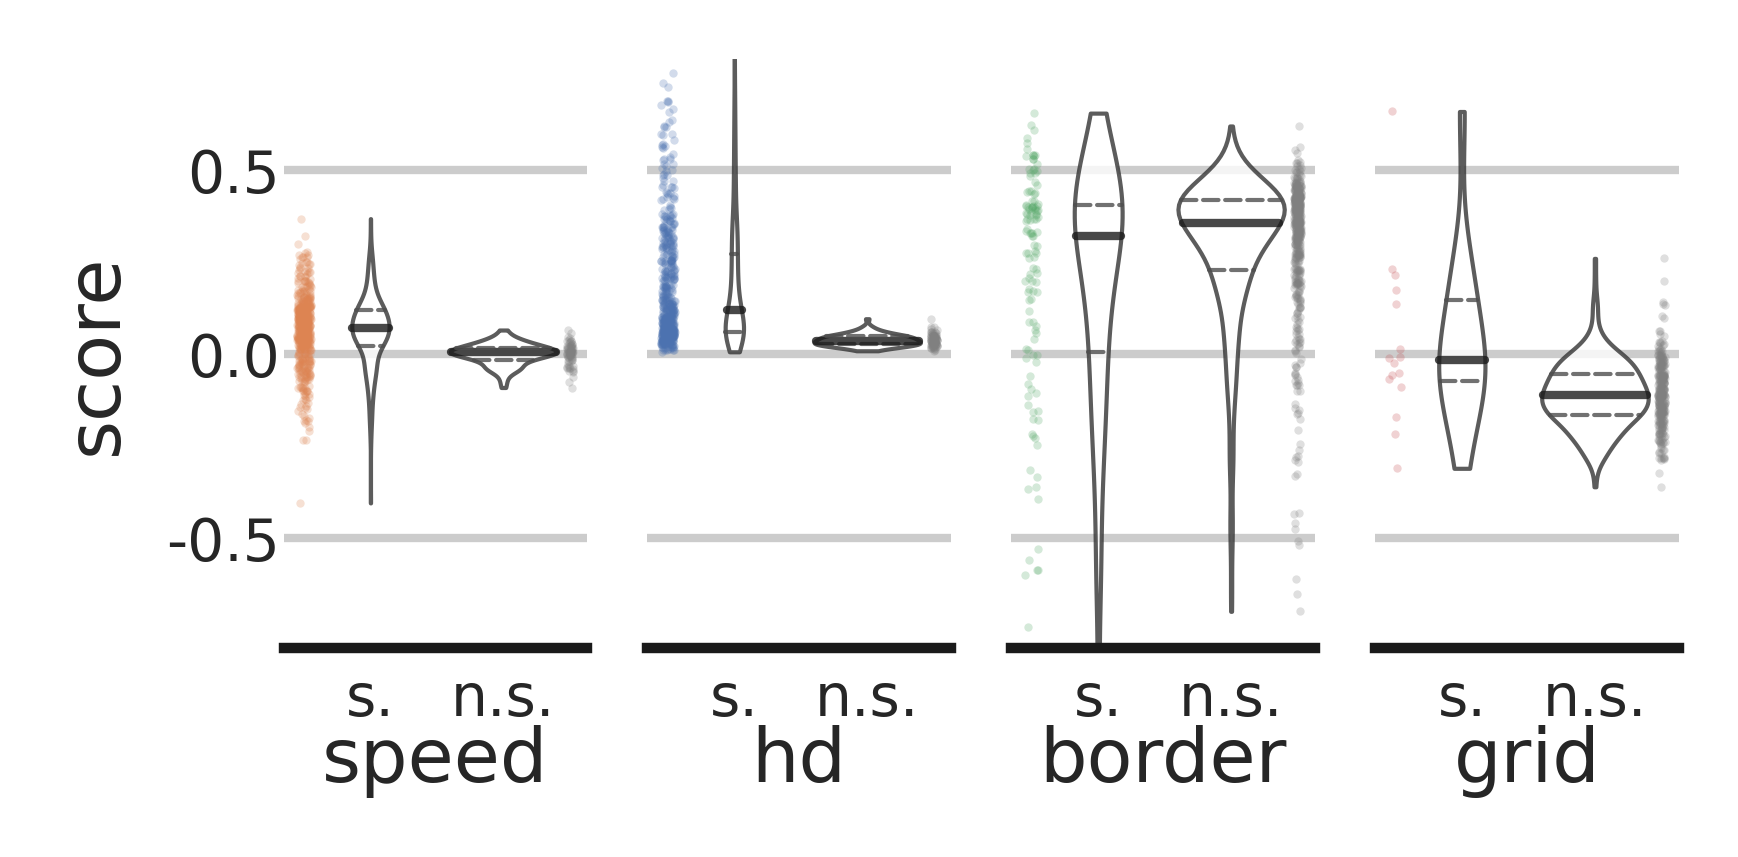

In [454]:
fontsize=9
tick_fontsize=7
dpi=1200
type_color = {'true': 'k',
              'hd': analyses_colors[0],
              'sp': analyses_colors[1],
              'speed': analyses_colors[1],
              'border': analyses_colors[2],
              'grid': analyses_colors[3],
              'pos': analyses_colors[4]}

for unit_type in ['cell']:#['cell', 'mua']:

    analyses = ['speed', 'hd', 'border', 'grid']
    f, ax = plt.subplots(1,4, figsize=(3,1.3), dpi=600)
    
    sns.set_style('whitegrid')
    for ii, analysis in enumerate(analyses):
        data_subset = metric_scores[ (metric_scores['unit_type']==unit_type) & 
                                        (metric_scores['analysis_type']==analysis) & 
                                        (metric_scores['session_valid']) ]
        data_subset = data_subset.astype({'sig': 'bool'})        
        data_subset = data_subset.astype({'sig': 'str'})

        sns.violinplot(data=data_subset, y='score', x='sig', order=['True', 'False'], color='white', cut=0, inner='quartile', linewidth=0.5, ax=ax[ii]) 
#         sns.violinplot(data=data_subset, x='score', hue='sig', order=['True', 'False'], split='True', scale='count', color='white', cut=0, inner='quartile', linecolor='0.1', ax=ax[ii]) 
        
        for l in ax[ii].lines:
            l.set_linestyle('--')
            l.set_linewidth(0.5)
            l.set_color('0.3')
            l.set_alpha(0.8)
        for l in ax[ii].lines[1::3]:
            l.set_linestyle('-')
            l.set_linewidth(1)
            l.set_color('0.1')
            l.set_alpha(0.8)
        for c in ax[ii].collections:
            c.set_edgecolor('0.2')
            c.set_alpha(0.8)
        
            
        sig_points = data_subset.sig=='True'
        ax[ii].scatter(y=data_subset['score'][sig_points], x=-0.5 + 0.1*(np.random.rand(sig_points.sum())-0.5), s=1, color=type_color[analysis], edgecolors=None, alpha=0.25,  linewidth=0)
        
        sig_points = data_subset.sig=='False'
        ax[ii].scatter(y=data_subset['score'][sig_points], x=1.5 + 0.05*(np.random.rand(sig_points.sum())-0.5), s=1, color='grey', alpha=0.25,  edgecolors=None, linewidth=0)

        
#         data_subset_sig = metric_scores[ (metric_scores['unit_type']==unit_type) & 
#                                         (metric_scores['analysis_type']==analysis) & 
#                                         (metric_scores['sig']) &
#                                         (metric_scores['session_valid']) ]

#         sns.violinplot(data=data_subset_sig, x='score', color='white', cut=0, ax=ax[ii],  inner='quartile')  
#         #sns.boxplot(data=data_subset_sig, x='score', color='white', whis=100, ax=ax[ii])
#         sns.stripplot(data=data_subset_sig, x='score', color=type_color[analysis], alpha=0.5, ax=ax[ii])

#         data_subset = metric_scores[ (metric_scores['unit_type']==unit_type) & 
#                                         (metric_scores['analysis_type']==analysis) &
#                                         (metric_scores['session_valid']) ]

#         sns.stripplot(data=data_subset, x='score', color='grey', alpha=0.1, jitter=0.2, ax=ax[ii])
        for pos in ['left', 'top', 'right']:
            ax[ii].spines[pos].set_visible(False)
        ax[ii].spines['bottom'].set_color('k')
        
        ax[ii].set_ylabel('')
        ax[ii].set_ylim([-0.8,0.8])
        yticks = ax[ii].get_yticks() 
        ax[ii].set_yticklabels(np.around(yticks,1))
         
        if ii==0:
            yticklabels=ax[ii].get_yticklabels() 
            for l in yticklabels:
                pos = l.get_position()
                l.set_position((pos[0]+0.25, pos[1]))
            ax[ii].set_yticklabels(yticklabels, fontsize=tick_fontsize)
        else:
            ax[ii].set_yticklabels([])

            
        ax[ii].set_xticklabels(['s.', 'n.s.'], fontsize=tick_fontsize)
        xticklabels=ax[ii].get_xticklabels() 
        for l in yticklabels:
            pos = l.get_position()
            #l.set_position((pos[0], pos[1]+0.2))
        ax[ii].set_xticklabels(xticklabels, fontsize=tick_fontsize,va='bottom')
        ax[ii].set_xlabel(analysis, fontsize=fontsize, va='center')

        #ax[ii].set_frame_on(False)
        #ax[ii].get_yaxis().tick_r()
    ax[0].set_ylabel('score', fontsize=fontsize)

    #f.savefig(fig5_path/(f'MetricsScores_{unit_type}2.pdf'), bbox_inches='tight', dpi=dpi)
    f.savefig(fig5_path/(f'MetricsScores_{unit_type}2.png'), bbox_inches='tight', dpi=dpi)

In [943]:
type_color

{'true': 'k',
 'hd': '#4C72B0',
 'sp': '#DD8452',
 'border': '#55A868',
 'grid': '#C44E52',
 'pos': '#8172B3'}

In [200]:
list(ax[ii].get_yticklabels())

[Text(0, 0, 'True'), Text(0, 1, 'False')]

## Units Model Scores

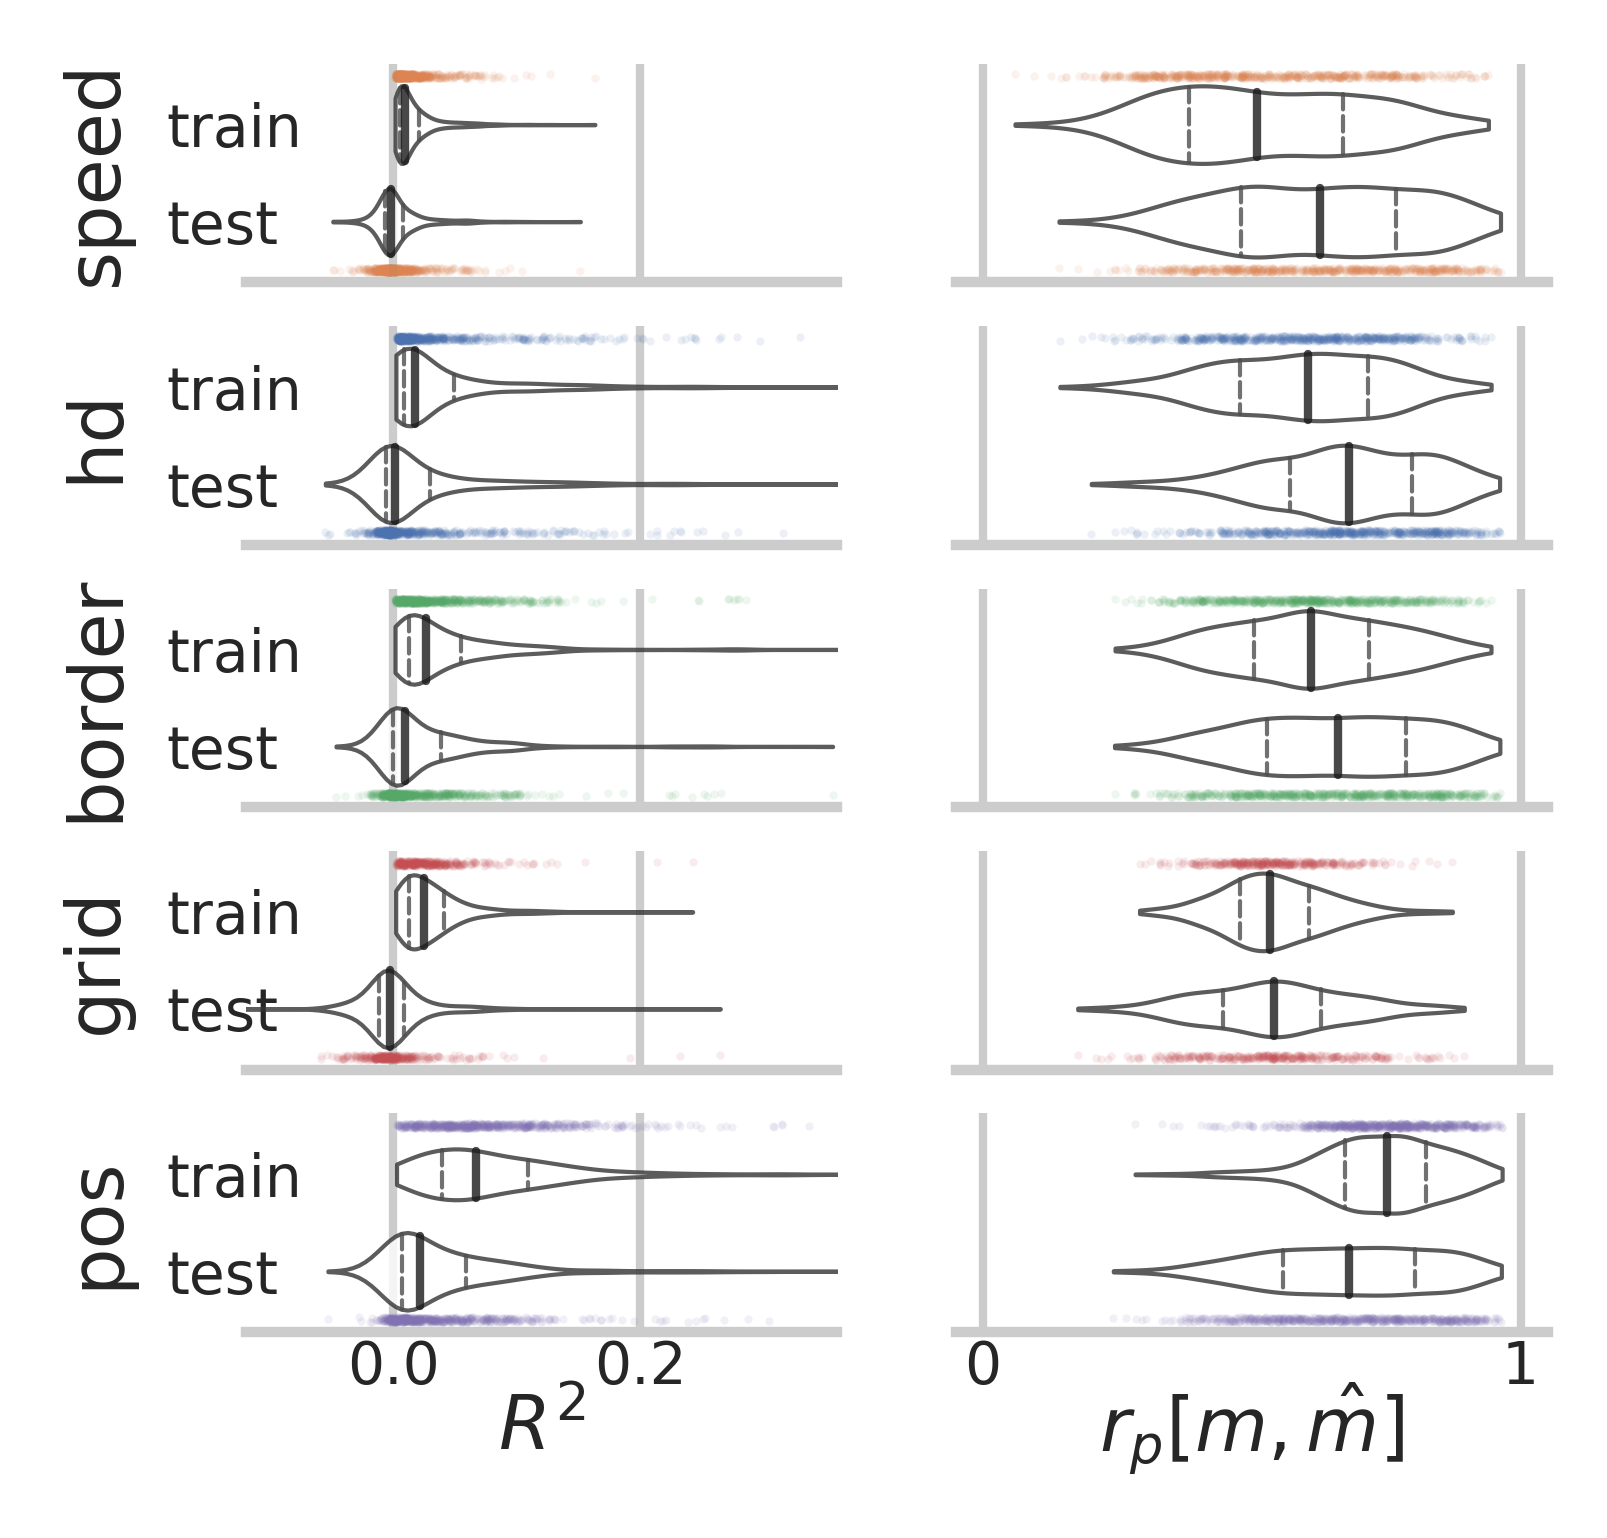

In [452]:
label_fontsize=9
tick_fontsize=7
dpi=1200
type_color = {'hd': analyses_colors[0],
              'speed': analyses_colors[1],
              'border': analyses_colors[2],
              'grid': analyses_colors[3],
              'pos': analyses_colors[4]}


for unit_type in ['cell']:#['cell', 'mua']:
    
    #f, ax = plt.subplots(5,2, figsize=(2.8,3), constrained_layout=True, dpi=600)
    f, ax = plt.subplots(5,2, figsize=(2.8,2.8), dpi=600)
    for jj, metric in enumerate(['r2', 'map_r']):
        analyses = ['speed', 'hd', 'border', 'grid', 'pos']
        sns.set_style('whitegrid')
        for ii, analysis in enumerate(analyses):
            data_subset = model_scores[ (model_scores['unit_type']==unit_type) & 
                                        (model_scores['model']==analysis) & 
                                        (model_scores['metric']==metric) &
                                        (model_scores['session_valid']) 
                                      ]
            data_subset = data_subset[~data_subset.isin([np.nan, np.inf, -np.inf]).any(1)]

            #sns.boxplot(data=data_subset, x='value', y='split', color='white', whis=100, ax=ax[ii])
            sns.violinplot(data=data_subset, x='value', y='split', color='white', order=['train','test'], cut=0, ax=ax[ii,jj],inner='quartile', linewidth=0.5)  
            #sns.stripplot(data=data_subset, x='value', y='split', color=type_color[analysis], alpha=0.2, ax=ax[ii])

            for l in ax[ii,jj].lines:
                l.set_linestyle('--')
                l.set_linewidth(0.5)
                l.set_color('0.3')
                l.set_alpha(0.8)
            for l in ax[ii,jj].lines[1::3]:
                l.set_linestyle('-')
                l.set_linewidth(1)
                l.set_color('0.1')
                l.set_alpha(0.8)
            for c in ax[ii,jj].collections:
                c.set_edgecolor('0.2')
                #c.set_linewidth(1.5)
                c.set_alpha(0.8)

            split_points = data_subset.split == 'train'
            ax[ii,jj].scatter(x=data_subset['value'][split_points], y=-0.5 + 0.05*(np.random.rand(split_points.sum())-0.5),
                           s=1, facecolor=type_color[analysis], alpha=0.1,  edgecolors=None, linewidth=0)

            split_points = data_subset.split == 'test'
            ax[ii,jj].scatter(x=data_subset['value'][split_points], y=1.5 + 0.05*(np.random.rand(split_points.sum())-0.5),
                           s=1, facecolor=type_color[analysis], alpha=0.1, edgecolors=None, linewidth=0)


            if metric=='r2':
                ax[ii,jj].set_xlabel(r'$R^2$', fontsize=label_fontsize, va='center')
                if unit_type=='cell':
                    ax[ii,jj].set_xlim([-0.15,0.45])
                else:
                    ax[ii,jj].set_xlim([-0.2,0.45])
            elif metric=='map_r':
                ax[ii,jj].set_xlabel(r'$r_p[m,\hat{m}]$', fontsize=label_fontsize, va='center')
                ax[ii,jj].set_xlim([-0.05,1.05])

            if ii==4:
                xticks = ax[ii,jj].get_xticks() 
                if metric=='map_r':
                    ax[ii,jj].set_xticks([0,1])
                    ax[ii,jj].set_xticklabels([0, '1'], fontsize=tick_fontsize, va='center')
                else:
                    ax[ii,jj].set_xticklabels(np.around(xticks,1), fontsize=tick_fontsize, va='center')
                
                xticklabels=ax[ii,jj].get_xticklabels() 
                for l in xticklabels:
                    pos = l.get_position()
                    l.set_position((pos[0], pos[1]+0.2))
                ax[ii,jj].set_xticklabels(xticklabels, fontsize=tick_fontsize)
                
            else:
                ax[ii,jj].set_xticklabels([])
           
            if ii<4:
                ax[ii,jj].set_xlabel('')
                
            if jj==0:
                ax[ii, jj].set_ylabel(analysis, fontsize=label_fontsize)
                ax[ii, jj].set_yticklabels(['train', 'test'], fontsize=tick_fontsize, ha='left')
            else:
                ax[ii,jj].set_ylabel('')
                ax[ii,jj].set_yticklabels([])
            
            for pos in ['right', 'top', 'left']:
                ax[ii,jj].spines[pos].set_visible(False)


#f.savefig(fig5_path/(f'ModelScores_{unit_type}.pdf'), bbox_inches='tight', dpi=dpi)
f.savefig(fig5_path/(f'ModelScores_{unit_type}.png'), bbox_inches='tight', dpi=dpi)

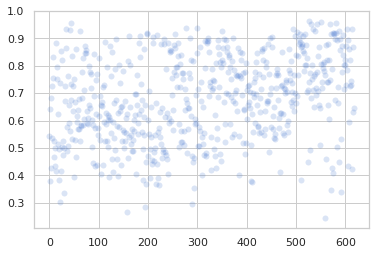

In [449]:
plt.scatter(np.arange(618), data_subset[split_points].value, alpha=0.2, edgecolors=None, linewidths=0)

## predicted map correlations

## Pair plot between metric and model scores

/home/alexgonzalez/anaconda3/envs/spk_phy2/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: Use the colorbar set_ticks() method instead.


[Text(1, 0, '$r_s$'), Text(1, 0, '0.5')]

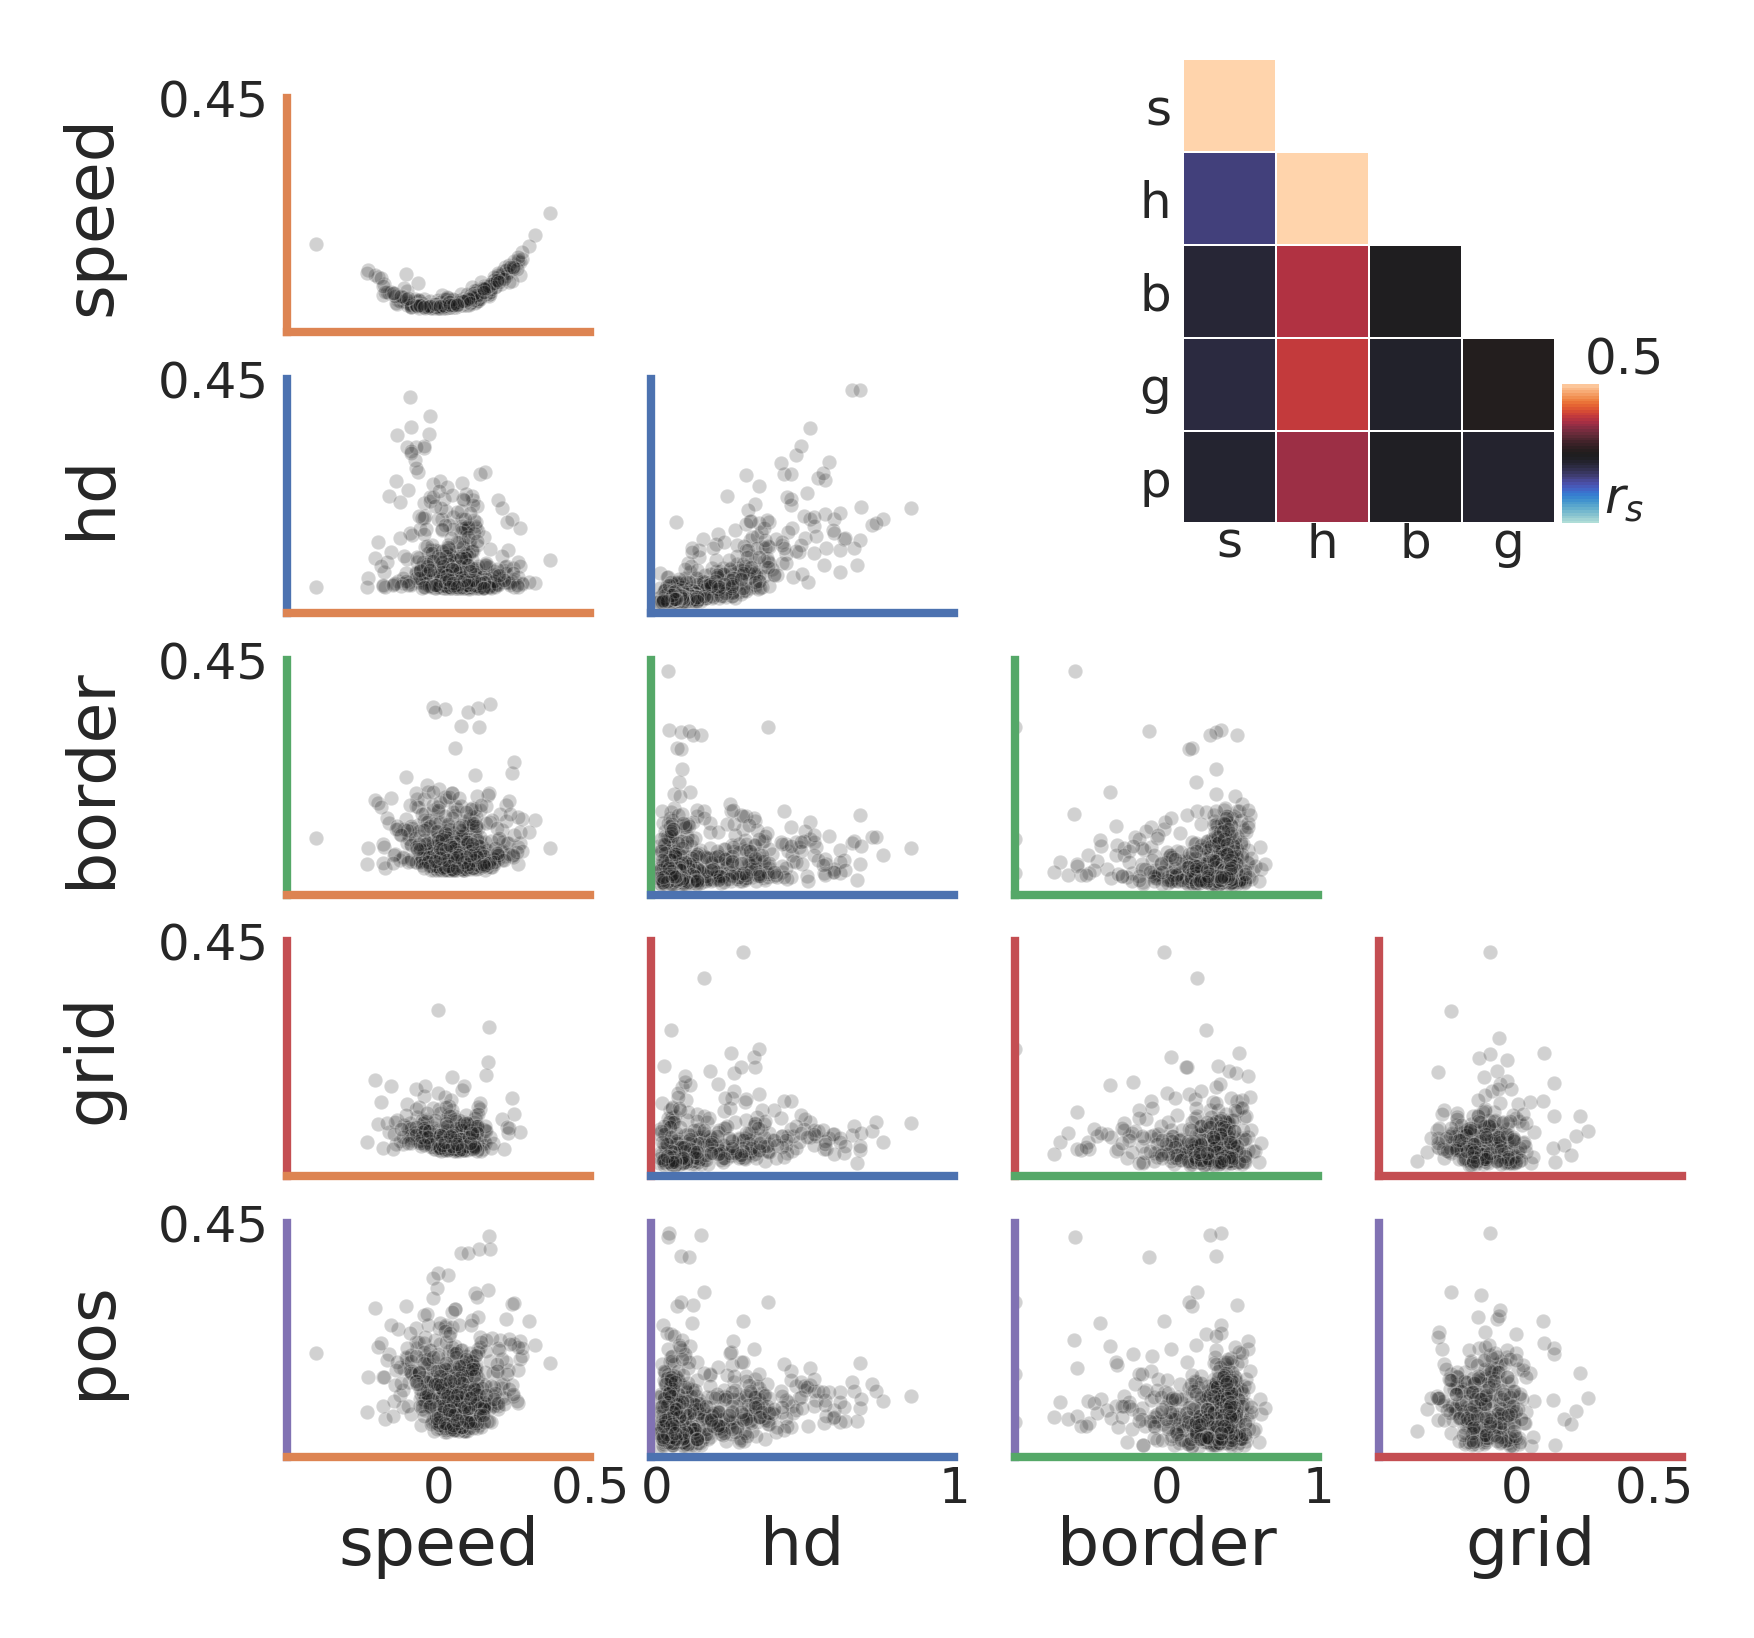

In [1004]:


model_metric = 'r2'
split = 'train'
unit_type = 'cell'

label_fontsize=8
tick_fontsize=6

metric_types = ['speed', 'hd', 'border', 'grid']
models = ['speed', 'hd', 'border', 'grid', 'pos']
type_color = {'true': 'k',
              'hd': analyses_colors[0],
              'sp': analyses_colors[1],
              'speed': analyses_colors[1],
              'border': analyses_colors[2],
              'grid': analyses_colors[3],
              'pos': analyses_colors[4]}


f = plt.figure(figsize=(3,3), dpi=600)# constrained_layout=True)
n_rows = 5
n_cols = 4
gs = f.add_gridspec(n_rows,n_cols)
sns.set_style('white')
ax = np.zeros((n_rows,n_cols), dtype=object)
for ii in range(n_rows):
    for jj in range(ii+1):
        if jj<n_cols:
            ax[ii, jj] = f.add_subplot(gs[ii,jj])
            for pos in ['right', 'top']:
                ax[ii,jj].spines[pos].set_visible(False)
                #ax[ii].get_xaxis().tick_bottom()
ax_s = f.add_subplot(gs[0:2,2:])
p = ax_s.get_position()
ax_s.set_position([p.x0+0.03, p.y0+0.05, p.width*0.9, p.height*0.9])

cc = np.zeros((n_rows, n_cols))
for ii in range(n_rows):
    model = models[ii]
    for jj in range(ii+1):
        if jj < n_cols:
            metric_type = metric_types[jj]
            ax[ii,jj].clear()
            if unit_type == 'all':
                y_subset =  [(model_scores['model']==model) & 
                            (model_scores['metric']==model_metric) & 
                            (model_scores['split']==split) & 
                            (model_scores['session_valid'])][0]

            else:
                y_subset =  [(model_scores['model']==model) & 
                            (model_scores['metric']==model_metric) & 
                            (model_scores['split']==split) &
                            (model_scores['unit_type']==unit_type) &
                            (model_scores['session_valid'])][0]

            suid = model_scores[y_subset].unit_id
            x_subset = (metric_scores['analysis_type']==metric_type) & (metric_scores['unit_id'].isin(suid))
            
            joint_data = model_scores.loc[y_subset, ['subject', 'unit_type', 'model', 'value']].copy()
            joint_data.loc[:, 'y_var'] = joint_data['value'].values.astype(float)
            joint_data.loc[:, 'x_var'] = metric_scores.loc[x_subset, 'score'].values.astype(float)
            joint_data.dropna(inplace=True)
            
            cc[ii,jj] = rs.spearman(joint_data.y_var, joint_data.x_var)
            sns.scatterplot(data=joint_data,x='x_var', y='y_var', color='k', alpha=0.2, legend=False, ax=ax[ii,jj], **{'s':3, 'edgecolors':None})
                                
            if metric_type=='speed':
                ax[ii,jj].set_xlim([-0.5, .5])    
            elif metric_type=='hd':
                ax[ii,jj].set_xlim([-0.02, 1])    
            elif metric_type=='border':
                ax[ii,jj].set_xlim([-1, 1])
            elif metric_type=='grid':
                ax[ii,jj].set_xlim([-0.5, 0.6])
                
            xmax = ax[ii,jj].get_xlim()[1]
            
            ax[ii,jj].set_xticklabels('')
            ax[ii,jj].set_yticklabels('')

            ax[ii,jj].set_xlabel('')
            ax[ii,jj].set_ylabel('')
                
            if jj==0:
                if model_metric=='r2':
                    ax[ii,jj].set_ylim([-0.05, 0.45])
                    ymax = ax[ii,jj].get_ylim()[1]
                    ax[ii,jj].set_yticks([0, ymax])
                    ax[ii,jj].set_yticklabels(['', ymax],fontsize=tick_fontsize)
                elif model_metric=='map_r':                  
                    ax[ii,jj].set_ylim([-0.02, 1])
                    ymax = ax[ii,jj].get_ylim()[1]
                    ax[ii,jj].set_yticks([0, 1])
                    ax[ii,jj].set_yticklabels(['', '1'], fontsize=tick_fontsize)
                elif model_metric=='coef':
                    if model=='grid':
                        ax[ii,jj].set_ylim((-1,3))
                    ymax = ax[ii,jj].get_ylim()[1]
                    ax[ii,jj].set_yticks([0, ymax])
                    ax[ii,jj].set_yticklabels([0, np.around(ymax,1)],fontsize=tick_fontsize)
                    
                yticklabels = ax[ii,jj].get_yticklabels()
                for l in yticklabels:
                    pos = l.get_position()
                    l.set_position((pos[0]+0.2, pos[1]))

                ax[ii,jj].set_ylabel(model, fontsize=label_fontsize)#, va='center', ha='right')                

            if ii==(n_rows-1):
                ax[ii,jj].set_xlabel(metric_type, fontsize=label_fontsize, va='center')
                
                #ax[ii,jj].set_xticklabels([0, xmax], va='bottom',  fontsize=tick_fontsize)
                #ax[ii,jj].xaxis.set_tick_params(pad=4)
                #ax[ii,jj].get_xaxis().tick_bottom()
                
                if metric_type in ['hd','border']:
                    ax[ii,jj].set_xticks([0, 1])
                    ax[ii,jj].set_xticklabels([0, 1], va='bottom',  fontsize=tick_fontsize)
                elif metric_type in ['speed', 'grid']:
                    ax[ii,jj].set_xticks([0, 0.5])
                    ax[ii,jj].set_xticklabels([0, 0.5], va='bottom',  fontsize=tick_fontsize)
                
                xticklabels = ax[ii,jj].get_xticklabels() 
                for l in xticklabels:
                    pos = l.get_position()
                    l.set_position((pos[0], pos[1]+0.1))
                
            ax[ii,jj].spines['left'].set_color(type_color[model])
            ax[ii,jj].spines['left'].set_linewidth(1)
            ax[ii,jj].spines['bottom'].set_color(type_color[metric_type])
            ax[ii,jj].spines['bottom'].set_linewidth(1)

cmap = 'icefire'
mask = np.zeros_like(cc)
mask[np.triu_indices_from(mask,1)] = True
vmax = 0.5
ax_s = sns.heatmap(cc, center=0, mask=mask, xticklabels=['s','h','b','g'], cmap=cmap, yticklabels=['s','h','b','g','p'], square=True, vmax=vmax, cbar=False, ax=ax_s, linewidths=0.1)

xticklabels = ax_s.get_xticklabels()
#ax_s.set_xticklabels(xticklabels, va='bottom', ha='center', fontsize=tick_fontsize)
ax_s.set_xticklabels(xticklabels, rotation=0, fontsize=tick_fontsize)
for l in xticklabels:
    pos = l.get_position()
    l.set_position((pos[0], pos[1]+0.18))


yticklabels = ax_s.get_yticklabels()
ax_s.set_yticklabels(yticklabels, rotation=0, fontsize=tick_fontsize)
#ax_s.set_yticklabels(l, va='center', ha='left', rotation=0, fontsize=tick_fontsize)
for l in yticklabels:
    pos = l.get_position()
    l.set_position((pos[0]+0.18, pos[1]))

cax = getColBar(ax_s, np.array((-vmax,vmax)), cmap=cmap, cax_pos=[1.02,0,0.1,0.3])
cax.set_yticks((0, vmax))
cax.set_yticklabels([r'$r_s$',np.around(vmax,1)], va='bottom', ha='center', fontsize=tick_fontsize)
#cax.set_ylabel(r'$r_s$', rotation=0, ha='right', va='top', fontsize=tick_fontsize)

In [1006]:
#f.savefig(fig5_path/(f'ModelvMetric_{unit_type}_{model_metric}_{split}.pdf'), bbox_inches='tight', dpi=600)
f.savefig(fig5_path/(f'ModelvMetric_{unit_type}_{model_metric}_{split}.png'), bbox_inches='tight', dpi=dpi)

## Explore within model metrics

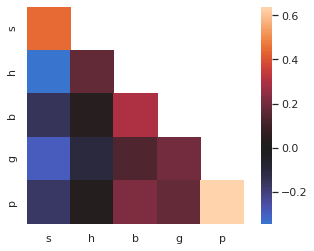

In [1014]:
models = ['speed', 'hd', 'border', 'grid', 'pos']
model_metric1 = 'r2'
model_metric2 = 'map_r'
split = 'train'
unit_type = 'cell'
CC = np.zeros((5,5))

for ii, model1 in enumerate(models):
    y_subset =[(model_scores['model']==model1) & 
                (model_scores['metric']==model_metric1) & 
                (model_scores['split']==split) &
                (model_scores['unit_type']==unit_type) &
                (model_scores['session_valid'])][0]

    for jj, model2 in enumerate(models):
        x_subset =[ (model_scores['model']==model2) & 
                    (model_scores['metric']==model_metric2) & 
                    (model_scores['split']==split) &
                    (model_scores['unit_type']==unit_type) &
                    (model_scores['session_valid'])][0]
        CC[ii,jj] = rs.spearman(model_scores.loc[y_subset, 'value'], model_scores.loc[x_subset, 'value'])

mask = np.zeros_like(CC)
mask[np.triu_indices_from(mask,1)] = True

f, ax = plt.subplots()
sns.heatmap(CC, mask=mask, xticklabels=['s','h','b','g', 'p'], yticklabels=['s','h','b','g','p'], center=0, square=True, cbar=True,cmap=cmap,ax=ax)
ax.set_xlabel(model_metric1)
ax.sey+
#f.savefig(fig5_path/(f'Model-{model_metric1}_v_Model-{model_metric2}_{unit_type}_{split}.png'), bbox_inches='tight', dpi=600)

## Explore Aggragate Models

In [1079]:
models = ['speed', 'hd', 'border', 'grid', 'pos']
model_metric = 'agg_coef'

split = 'train'
unit_type = ['cell']
    
r2_subset =[(model_scores['model']=='agg') & 
            (model_scores['metric']=='r2') & 
            (model_scores['split']==split) &
            (model_scores['unit_type'].isin(unit_type)) &
            (model_scores['session_valid'])][0]

#r2 = model_scores.loc[y_subset, 'value']
n_units = r2_subset.sum()


D = pd.DataFrame(index=range(n_units), columns=models)
for ii, model1 in enumerate(models):
    
    y_subset =[(model_scores['model']==model1) & 
                (model_scores['metric']==model_metric1) & 
                (model_scores['split']==split) &
                (model_scores['unit_type'].isin(unit_type)) &
                (model_scores['session_valid'])][0]
    D[model1]= model_scores.loc[y_subset, 'value'].values
    
D = D.dropna()

r2 = model_scores.loc[r2_subset, 'value'].values[D.index]

In [1080]:
D

speed        hd    border      grid       pos
1    0.007533  0.034043  0.018675  0.020086  0.049202
3    0.006301  0.033454  0.014243  0.013490  0.017966
6    0.012913  0.150917  0.073117  0.022138  0.105272
9    0.017185  0.062996  0.049700  0.018818  0.056583
10   0.006124  0.014183  0.025852  0.044360  0.084601
..        ...       ...       ...       ...       ...
608  0.008929  0.006329  0.056691  0.035247  0.111318
611  0.004767  0.007411  0.007088  0.015542  0.036427
614  0.008337  0.166637  0.029297  0.017934  0.082769
616  0.048166  0.009723  0.017769  0.009818  0.057652
617  0.033064  0.011316  0.017977  0.006606  0.038157

[356 rows x 5 columns]

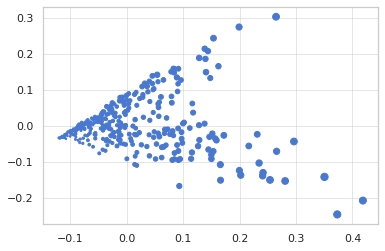

In [1023]:
import sklearn as sk
models_pca = sk.decomposition.PCA(n_components=2).fit_transform(D)
plt.scatter(*models_pca.T,s=r2*100)

In [316]:
rs = reload(rs)
zD = rs.zscore(D.values, axis=1)

In [1024]:
from umap import UMAP
method_kwargs = {'n_components': 3, 'n_neighbors': 20, 'min_dist': 0.00} # work well for cells only
#method_kwargs = {'n_components': 2, 'n_neighbors': 20, 'min_dist': 0.5}
np.random.seed(0)
models_umap = UMAP(**method_kwargs).fit_transform(D)

method_kwargs = {'n_components': 2, 'n_neighbors': 30, 'min_dist': 0}
models_umap_umap =  UMAP(**method_kwargs).fit_transform(models_umap)


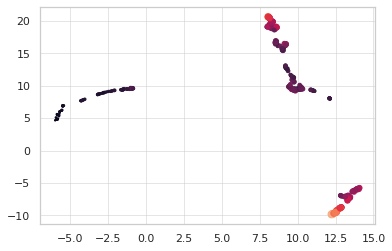

In [1025]:
plt.scatter(*models_umap_umap.T,s=r2*100,c=r2*100)

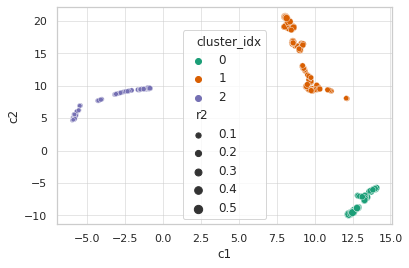

In [1075]:
n_cl = 3
m, idx, _ = sk.cluster.k_means(models_umap_umap, n_clusters=n_cl)

df = pd.DataFrame(models_umap_umap, columns=['c1', 'c2'])
df['r2'] = r2
df['cluster_idx'] = idx
sns.scatterplot(data=df, x='c1', y='c2', hue='cluster_idx', size='r2', palette='Dark2')


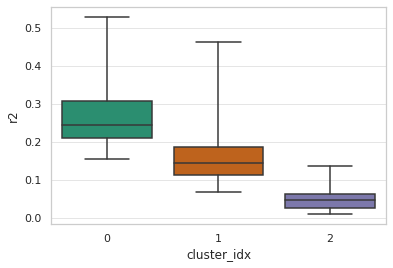

In [1081]:
sns.boxplot(data=df, x='cluster_idx', y='r2', palette='Dark2', whis=100)

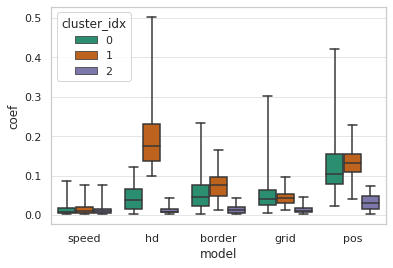

In [1072]:

df = D.melt(var_name='model',value_name='coef')
df['r2'] = np.tile(r2, 5)
df['cluster_idx'] = np.tile(idx,5)
sns.boxplot(x='model', y ='coef', hue='cluster_idx', data=df, whis=100, palette='Dark2')

In [1061]:
df = D.melt(var_name='model',value_name='coef')

(      model      coef
 0     speed  0.007533
 1     speed  0.006301
 2     speed  0.012913
 3     speed  0.017185
 4     speed  0.006124
 ...     ...       ...
 1775    pos  0.111318
 1776    pos  0.036427
 1777    pos  0.082769
 1778    pos  0.057652
 1779    pos  0.038157
 
 [1780 rows x 2 columns],
 1780)

In [1078]:
D

speed        hd    border      grid       pos
1    0.007533  0.034043  0.018675  0.020086  0.049202
3    0.006301  0.033454  0.014243  0.013490  0.017966
6    0.012913  0.150917  0.073117  0.022138  0.105272
9    0.017185  0.062996  0.049700  0.018818  0.056583
10   0.006124  0.014183  0.025852  0.044360  0.084601
..        ...       ...       ...       ...       ...
608  0.008929  0.006329  0.056691  0.035247  0.111318
611  0.004767  0.007411  0.007088  0.015542  0.036427
614  0.008337  0.166637  0.029297  0.017934  0.082769
616  0.048166  0.009723  0.017769  0.009818  0.057652
617  0.033064  0.011316  0.017977  0.006606  0.038157

[356 rows x 5 columns]

(<matplotlib.axes._subplots.AxesSubplot at 0x7fdf438a0588>,)

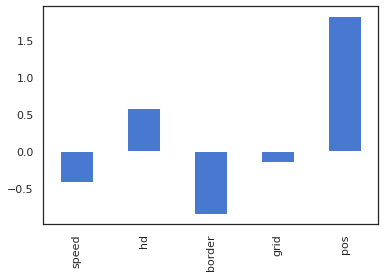

In [327]:
D.loc[idx==1].mean().plot.bar(), 
#D.loc[idx==2].mean().plot.bar(), 

In [120]:
from sklearn.manifold import TSNE
method_kwargs = {'n_components': 2, 'perplexity': 20, 'n_jobs': -1}
np.random.seed(0)
models_tsne = TSNE(**method_kwargs).fit_transform(D)


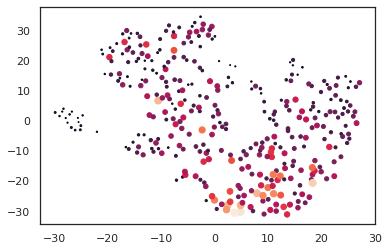

In [124]:
plt.scatter(*models_tsne.T,s=r2*100, c=r2*100)

In [935]:
f.savefig(fig5_path/(f'ModelvMetric_{unit_type}_{model_metric}_{split}.pdf'), bbox_inches='tight')

## Example Model Fits

In [392]:
@interact(model=['speed','hd','border','grid', 'pos'], thr=widgets.FloatSlider(min=-1, max=1, step=0.02), unit_type=['cell', 'mua', None], model_metric=['r2', 'map_r', 'coef','n_err'], split=['train', 'test'] )
def model_filter_units(model, thr, model_metric, split, unit_type=None):
    if unit_type is None:
        sub_table = model_scores.loc[ (model_scores.model==model)
                                      & (model_scores.metric==model_metric)
                                      & (model_scores.split==split) 
                                      & (model_scores.value>=thr) 
                                      & (model_scores.session_valid)]
    else:
        sub_table = model_scores.loc[ (model_scores.unit_type==unit_type) 
                                      & (model_scores.model==model)
                                      & (model_scores.metric==model_metric)
                                      & (model_scores.split==split) 
                                      & (model_scores.value>=thr) 
                                      & (model_scores.session_valid)]

    return sub_table.sort_values(by=['value'], ascending=False)

interactive(children=(Dropdown(description='model', options=('speed', 'hd', 'border', 'grid', 'pos'), value='s…

In [52]:
model_metric='coef'
thr = 0.1
tbl = model_scores.groupby(['session','unit_id','metric'], as_index=False).mean()
tbl = tbl[tbl.metric==model_metric ].sort_values(by=['value'], ascending=False)
tbl[tbl.session_valid][10:30]

session  unit_id metric  session_unit_id  session_pct_cov  \
6776  Li_OF_062918      525   coef               17             0.90   
6524  Li_OF_062718      462   coef                9             0.93   
8636  NE_OF_061818      959   coef               17             0.97   
4928  Li_OF_053018       63   coef               20             0.95   
1452  Cl_OF_012419     1925   coef               13             0.94   
7724  NE_OF_053018      727   coef               33             0.96   
4544  Cl_OF_122218     1730   coef               15             0.96   
3304  Cl_OF_120618     1420   coef                3             0.90   
6428  Li_OF_062618      438   coef                8             0.95   
4916  Li_OF_053018       60   coef               17             0.95   
6940  Li_OF_070618      566   coef                2             0.97   
6516  Li_OF_062718      460   coef                7             0.93   
6336  Li_OF_062518      415   coef                4             0.97   
6248  Li_OF_062018      393   coef               14             0.98   
6848  Li_OF_070218      543   coef                8             0.97   
6172  Li_OF_061818      374   coef               22             0.94   
6992  Li_OF_070618      579   coef               15             0.97   
6408  Li_OF_062618      433   coef                3             0.95   
5396  Li_OF_060718      180   coef                4             0.94   
6892  Li_OF_070218      554   coef               19             0.97   

      session_valid  tt  tt_cl     value  
6776           True  10      0  3.679175  
6524           True  10      0  3.635231  
8636           True   7      0  3.541906  
4928           True   7     18  3.518906  
1452           True  10     13  3.467283  
7724           True  16      8  3.453851  
4544           True  10     14  3.421234  
3304           True   4     19  3.388762  
6428           True  10      0  3.375698  
4916           True   7     10  3.335855  
6940           True   9      5  3.335852  
6516           True   8     15  3.276380  
6336           True   8     16  3.241772  
6248           True   7      4  3.222942  
6848           True  14      0  3.180790  
6172           True  14      0  3.112249  
6992           True  14      0  3.111031  
6408           True   8      0  3.091968  
5396           True   3     19  3.084404  
6892           True   9     11  3.027307

In [991]:
uuid = 113
model_scores[model_scores.unit_id==uuid].groupby(['model', 'metric']).mean()

unit_id  session_unit_id  session_pct_cov  session_valid  tt  \
model  metric                                                                   
agg    agg_coef      113                7             0.93           True  10   
       coef          113                7             0.93           True  10   
       map_r         113                7             0.93           True  10   
       n_err         113                7             0.93           True  10   
       r2            113                7             0.93           True  10   
border agg_coef      113                7             0.93           True  10   
       coef          113                7             0.93           True  10   
       map_r         113                7             0.93           True  10   
       n_err         113                7             0.93           True  10   
       r2            113                7             0.93           True  10   
grid   agg_coef      113                7             0.93           True  10   
       coef          113                7             0.93           True  10   
       map_r         113                7             0.93           True  10   
       n_err         113                7             0.93           True  10   
       r2            113                7             0.93           True  10   
hd     agg_coef      113                7             0.93           True  10   
       coef          113                7             0.93           True  10   
       map_r         113                7             0.93           True  10   
       n_err         113                7             0.93           True  10   
       r2            113                7             0.93           True  10   
pos    agg_coef      113                7             0.93           True  10   
       coef          113                7             0.93           True  10   
       map_r         113                7             0.93           True  10   
       n_err         113                7             0.93           True  10   
       r2            113                7             0.93           True  10   
speed  agg_coef      113                7             0.93           True  10   
       coef          113                7             0.93           True  10   
       map_r         113                7             0.93           True  10   
       n_err         113                7             0.93           True  10   
       r2            113                7             0.93           True  10   

                 tt_cl     value  
model  metric                     
agg    agg_coef      9       NaN  
       coef          9       NaN  
       map_r         9  0.886415  
       n_err         9  1.899304  
       r2            9  0.351982  
border agg_coef      9 -0.172054  
       coef          9  0.842523  
       map_r         9  0.503098  
       n_err         9  2.238844  
       r2            9  0.098171  
grid   agg_coef      9 -0.048750  
       coef          9  1.334576  
       map_r         9  0.852854  
       n_err         9  1.990806  
       r2            9  0.317276  
hd     agg_coef      9  0.360077  
       coef          9  1.353042  
       map_r         9  0.350547  
       n_err         9  2.327751  
       r2            9  0.017145  
pos    agg_coef      9  1.448815  
       coef          9  1.393035  
       map_r         9  0.883033  
       n_err         9  1.938633  
       r2            9  0.325230  
speed  agg_coef      9 -0.539853  
       coef          9 -0.887751  
       map_r         9  0.296396  
       n_err         9  2.351114  
       r2            9 -0.002555

In [992]:
subject, session, suid = model_scores.loc[model_scores.unit_id==uuid, ['subject','session','session_unit_id']].iloc[0]

In [993]:
from TreeMazeAnalyses2.Analyses import subject_info as si
si = reload(si)
#subject = 'Li'
#session = 'Li_OF_061318'
session_info = si.SubjectSessionInfo(subject, session)

In [994]:
sem=session_info.get_encoding_models()

Getting Encoding Models


/home/alexgonzalez/anaconda3/envs/spk_phy2/lib/python3.7/site-packages/scipy/signal/filter_design.py:1631: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  "results may be meaningless", BadCoefficients)


speed model completed. 3.77secs
hd model completed. 3.21secs
ha model completed. 3.69secs
border model completed. 1.96secs
grid model completed. 15.72secs
pos model completed. 12.38secs
agg model completed. 3.45secs


/home/alexgonzalez/anaconda3/envs/spk_phy2/lib/python3.7/site-packages/pandas/core/internals/blocks.py:849: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  arr_value = np.array(value)


In [422]:
sem.scores[(sem.scores.unit_id==4) & (sem.scores.model=='hd')]

unit_id    metric  split     value model
56        4  agg_coef   test  0.721068    hd
57        4  agg_coef  train  0.721068    hd
58        4       ar2   test  0.203869    hd
59        4       ar2  train  0.246214    hd
60        4      coef   test  0.863881    hd
61        4      coef  train  0.863881    hd
62        4       err   test  6.366532    hd
63        4       err  train  6.300950    hd
64        4     map_r   test  0.771297    hd
65        4     map_r  train  0.812494    hd
66        4     n_err   test  1.478866    hd
67        4     n_err  train  1.452232    hd
68        4        r2   test  0.208372    hd
69        4        r2  train  0.247279    hd

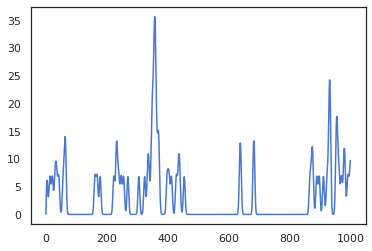

In [411]:
fold=0
plt.plot(sem.grid_model.get_response_fold(fold)[1][suid][:1000])
plt.plot(sem.grid_model.predict_model_fold(fold)[1][suid][:1000], alpha=0.6)

In [414]:
t = sem.grid_model.scores.dropna()
t[t.unit_id==suid]

fold unit_id    metric  split     value
700     3       7        r2  train  0.303261
701     3       7        r2   test  0.331292
702     3       7       ar2  train  0.302731
703     3       7       ar2   test  0.329280
704     3       7       err  train  5.879802
705     3       7       err   test  6.855730
706     3       7     n_err  train  1.958891
707     3       7     n_err   test  2.022720
708     3       7     map_r  train  0.873152
709     3       7     map_r   test  0.832556
1126    3       7      coef  train  1.334576
1127    3       7      coef   test  1.334576
1336    3       7  agg_coef  train -0.048750
1337    3       7  agg_coef   test -0.048750

In [995]:
behav = session_info.get_track_data()
x, y, speed = behav['x'], behav['y'], behav['sp']
ha, hd = behav['ha'], behav['hd']
t = behav['t']
fr = session_info.get_fr()
spks = session_info.get_binned_spikes()
fr_maps = session_info.get_fr_maps()
params = session_info.task_params

spatial_funcs = reload(spatial_funcs)
#f = spatial_funcs.get_spatial_map_function('fr', **params)

In [1385]:
# %%time
# spatial_funcs = reload(spatial_funcs)
# sem = spatial_funcs.AllSpatialEncodingModels(x,y,speed,ha,hd,neural_data=fr, **params)
# scores = sem.get_all_models()

speed model completed. 3.78secs
hd model completed. 3.40secs
ha model completed. 3.48secs
border model completed. 2.01secs
grid model completed. 26.15secs
pos model completed. 16.98secs
CPU times: user 3min 54s, sys: 3min 55s, total: 7min 49s
Wall time: 55.8 s


In [996]:
mpl.rcParams['lines.solid_capstyle'] = 'round'
mpl.rcParams['lines.dash_capstyle'] = 'round'

def colorline2(
    x, y, z=None, colors=None, cmap=plt.get_cmap('copper'), norm=plt.Normalize(0.0, 1.0),
        linewidth=3, alpha=1.0,ax=None):
    """
    http://nbviewer.ipython.org/github/dpsanders/matplotlib-examples/blob/master/colorline.ipynb
    http://matplotlib.org/examples/pylab_examples/multicolored_line.html
    Plot a colored line with coordinates x and y
    Optionally specify colors in the array z
    Optionally specify a colormap, a norm function and a line width
    """

    # Default colors equally spaced on [0,1]:
    if z is None:
        z = np.linspace(0.0, 1.0, len(x))

    # Special case if a single number:
    if not hasattr(z, "__iter__"):  # to check for numerical input -- this is a hack
        z = np.array([z])

    z = np.asarray(z)

    segments = make_segments(x, y)
    if colors is None:
        lc = mcoll.LineCollection(segments, array=z, cmap=cmap, norm=norm,
                              linewidth=linewidth, alpha=alpha,zorder=1)
    else:
        lc = mcoll.LineCollection(segments, colors=colors,
                              linewidth=linewidth, alpha=alpha,zorder=1)
    if ax is None:
        ax = plt.gca()
    ax.add_collection(lc)

    return lc


@interact(unit=np.arange(session_info.n_units), i=widgets.IntSlider(max=10000,step=500), fold=widgets.IntSlider(min=0,max=4), wl=widgets.IntSlider(value=500,step=500,max=1000)) 
def plot_trace_segment(unit=0, i=0, wl=500, fold=0):
    f,ax = plt.subplots(figsize=(4,4))
    
    samps = np.arange(sem.n_samples)
    test_bool_ids = sem.crossval_samp_ids==fold
    test_samps = samps[test_bool_ids]
    
    window = np.arange(wl) + i
    
    ax.plot(x,y, linewidth=0.2, color='0.5',zorder=-1)

    cmap='rainbow'
    colors = plt.cm.get_cmap(cmap)(np.arange(wl)/wl)
    xx, yy = sem.pos_model.x_pos[test_bool_ids], sem.pos_model.y_pos[test_bool_ids]
    ss = sem.pos_model.get_response_fold(fold)[1][unit]

    colorline2( xx[window] , yy[window], colors=colors, linewidth=7, ax=ax)
    
    #ax.plot(x[window],y[window], '0.2')
    ax.scatter(xx[window],yy[window],s=ss[window]*0.5,  color='0.2' , alpha=0.5)
    ax.scatter(xx[window][0], yy[window][0], s=75, color=colors[0] ,marker='d',zorder=10)
    ax.scatter(xx[window][-1], yy[window][-1], s=75, color=colors[-1], marker='s', zorder=10)
    ax.axis("off")
    ax.set_rasterized(False)

#f.savefig(p/"trace_w.pdf",dpi=300, bbox_inches='tight', pad_inches=0.2)


interactive(children=(Dropdown(description='unit', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, …

In [997]:
suid=7

fold=3
i=5000
wl=1000
window = np.arange(wl) + i

samples = np.arange(sem.n_samples)
fold_test_ids_bool = sem.crossval_samp_ids==fold
sp_valid_ids_bool = sem.valid_sp_samps

fold_test_samples = samples[fold_test_ids_bool]
fold_test_window_samples = fold_test_samples[window]

fold_test_samples_sp = samples[fold_test_ids_bool & sp_valid_ids_bool]
fold_test_window_samples_sp = np.intersect1d(fold_test_samples_sp,fold_test_window_samples)

within_fold_samples = np.arange(len(fold_test_samples))
within_fold_window_samples = window

within_fold_samples_sp = np.arange(len(fold_test_samples_sp))
within_fold_window_samples_sp = window[np.in1d(fold_test_window_samples, fold_test_window_samples_sp)]

models = ['true', 'sp', 'hd', 'pos', 'grid', 'border']
resp = {}

resp['true'] = sem.pos_model.get_response_fold(fold)[1][suid, within_fold_window_samples]

resp['sp'] = sem.speed_model.predict_model_fold(fold)[1][suid, within_fold_window_samples_sp]
resp['hd']= sem.hd_model.predict_model_fold(fold)[1][suid, within_fold_window_samples_sp]

resp['pos'] = sem.pos_model.predict_model_fold(fold)[1][suid, within_fold_window_samples]
resp['grid'] = sem.grid_model.predict_model_fold(fold)[1][suid, within_fold_window_samples]
resp['border'] = sem.border_model.predict_model_fold(fold)[1][suid, within_fold_window_samples]

sm = {}
for m in models:
    resp[m] = resp[m]/resp[m].max()
    if m in ['sp', 'hd']:
        x_win = sem.x[fold_test_window_samples_sp]
        y_win = sem.y[fold_test_window_samples_sp]
    else:
        x_win = sem.x[fold_test_window_samples]
        y_win = sem.y[fold_test_window_samples]
    
    sm[m] = sem.spatial_map_function(resp[m],x_win,y_win)

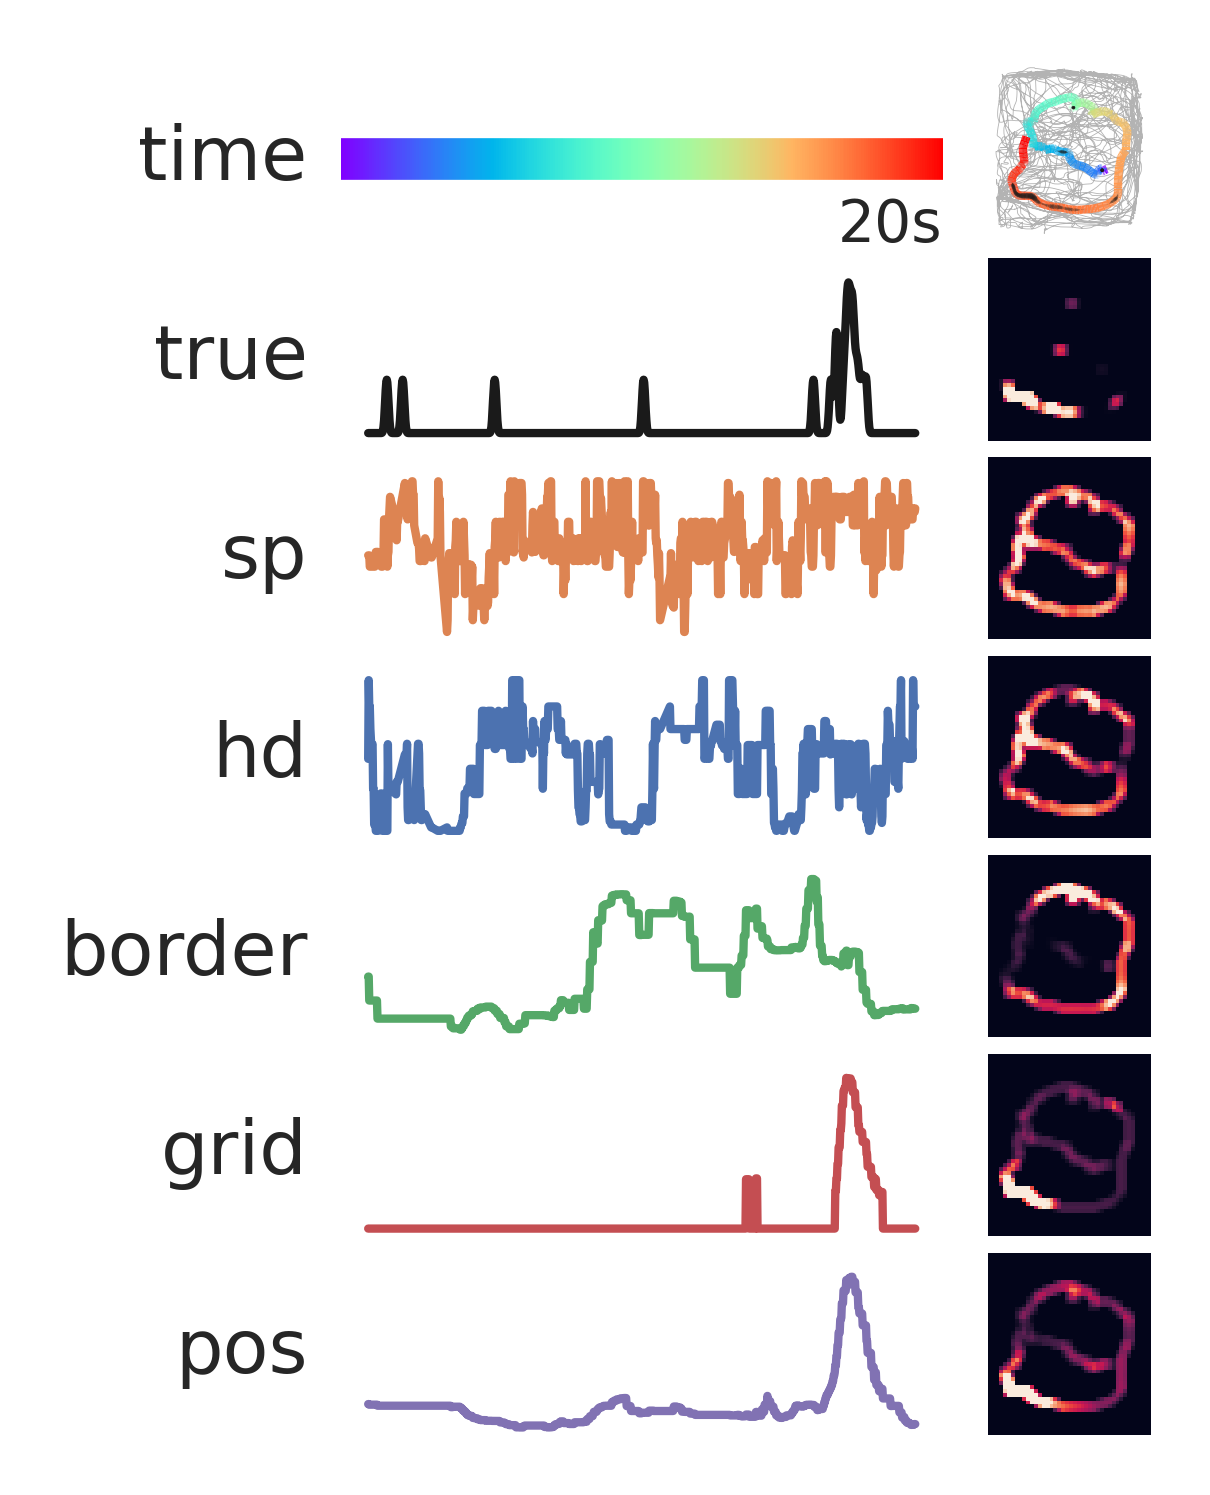

In [1001]:
label_fontsize= 9
tick_fontsize=7

models = ['true', 'sp','hd', 'border', 'grid', 'pos']
sns.set_style('white')
analyses_colors = sns.color_palette(palette='deep', as_cmap=True)
type_color = {'true': 'k',
              'hd': analyses_colors[0],
              'sp': analyses_colors[1],
              'border': analyses_colors[2],
              'grid': analyses_colors[3],
              'pos': analyses_colors[4]}
cmap='rainbow'
colors = plt.cm.get_cmap(cmap)(np.arange(wl)/wl)

f = plt.figure(figsize=(2,3), dpi=600)

gs = f.add_gridspec(7,3,)
ax = [[]]*14
for ii in range(7):
    jj = ii*2
    ax[jj] = f.add_subplot(gs[ii, :2])
    ax[jj+1] = f.add_subplot(gs[ii, 2])
    
colorline(np.linspace(0,1,wl), np.ones(wl) ,colors=colors,linewidth=5, ax=ax[0])
ax[0].set_ylim([0.8,1.2])
#ax[0].text(0,0.8, "t=0s",fontsize=label_fontsize, ha='center')
ax[0].text(1,0.8, f"{wl*0.02:0.0f}s", fontsize=tick_fontsize, ha='right')
for pos in ['left', 'top', 'right', 'bottom']:
        ax[0].spines[pos].set_visible(False)
ax[0].set_yticks([])
ax[0].set_yticklabels('')
ax[0].set_xticks([])
ax[0].set_xticklabels('')
ax[0].set_ylabel('time', fontsize=label_fontsize, va='center', ha='right',  rotation=0)


x_win = sem.x[fold_test_window_samples]
y_win = sem.y[fold_test_window_samples]    

colorline( x_win , y_win, colors=colors, linewidth=1, ax=ax[1], alpha=1)
ax[1].plot(x,y, linewidth=0.1, color='0.7',zorder=-1)
ax[1].scatter(x_win, y_win,s=resp['true']*.5,  color='0.1' , alpha=0.3, edgecolors=None, linewidth=0)
ax[1].axis("off")
ax[1].set_rasterized(True)
ax[1].set_aspect('equal', 'box')
p = ax[1].get_position()
ax[1].set_position([p.x0-0.06, p.y0, p.width*1.1, p.height*1.1])

for ii,model in enumerate(models):
    jj = ii*2+3
    sns.heatmap(sm[model],ax=ax[jj],cbar=False,square=True, robust=True)
    ax[jj].axis('off')
    ax[jj].invert_yaxis()
    ax[jj].set_rasterized(True)
    
    p = ax[jj].get_position()
    ax[jj].set_position([p.x0-0.06, p.y0, p.width*1.1, p.height*1.1])
    
t = behav['t']
for ii,model in enumerate(models):
    jj = ii*2+2
    if model in ['sp','hd']:
        tw = t[fold_test_window_samples_sp]
    else:
        tw = t[fold_test_window_samples]

    ax[jj].plot(tw, resp[model], linewidth=1, color=type_color[model])
    ax[jj].set_yticks([])
    ax[jj].set_yticklabels('')
    ax[jj].set_xticklabels('')
    for pos in ['left', 'top', 'right', 'bottom']:
        ax[jj].spines[pos].set_visible(False)
    ax[jj].set_ylabel(model, fontsize=label_fontsize, rotation=0, ha='right', va='center')
    
# #ax[12].set_xlabel(' fr [spks/s] ')
#f.savefig(fig5_path/(f'ExampleModelsFits{uuid}_i{i}_fold{fold}.pdf'), bbox_inches='tight', dpi=dpi)
f.savefig(fig5_path/(f'ExampleModelsFits{uuid}_i{i}_fold{fold}.png'), bbox_inches='tight', dpi=dpi)

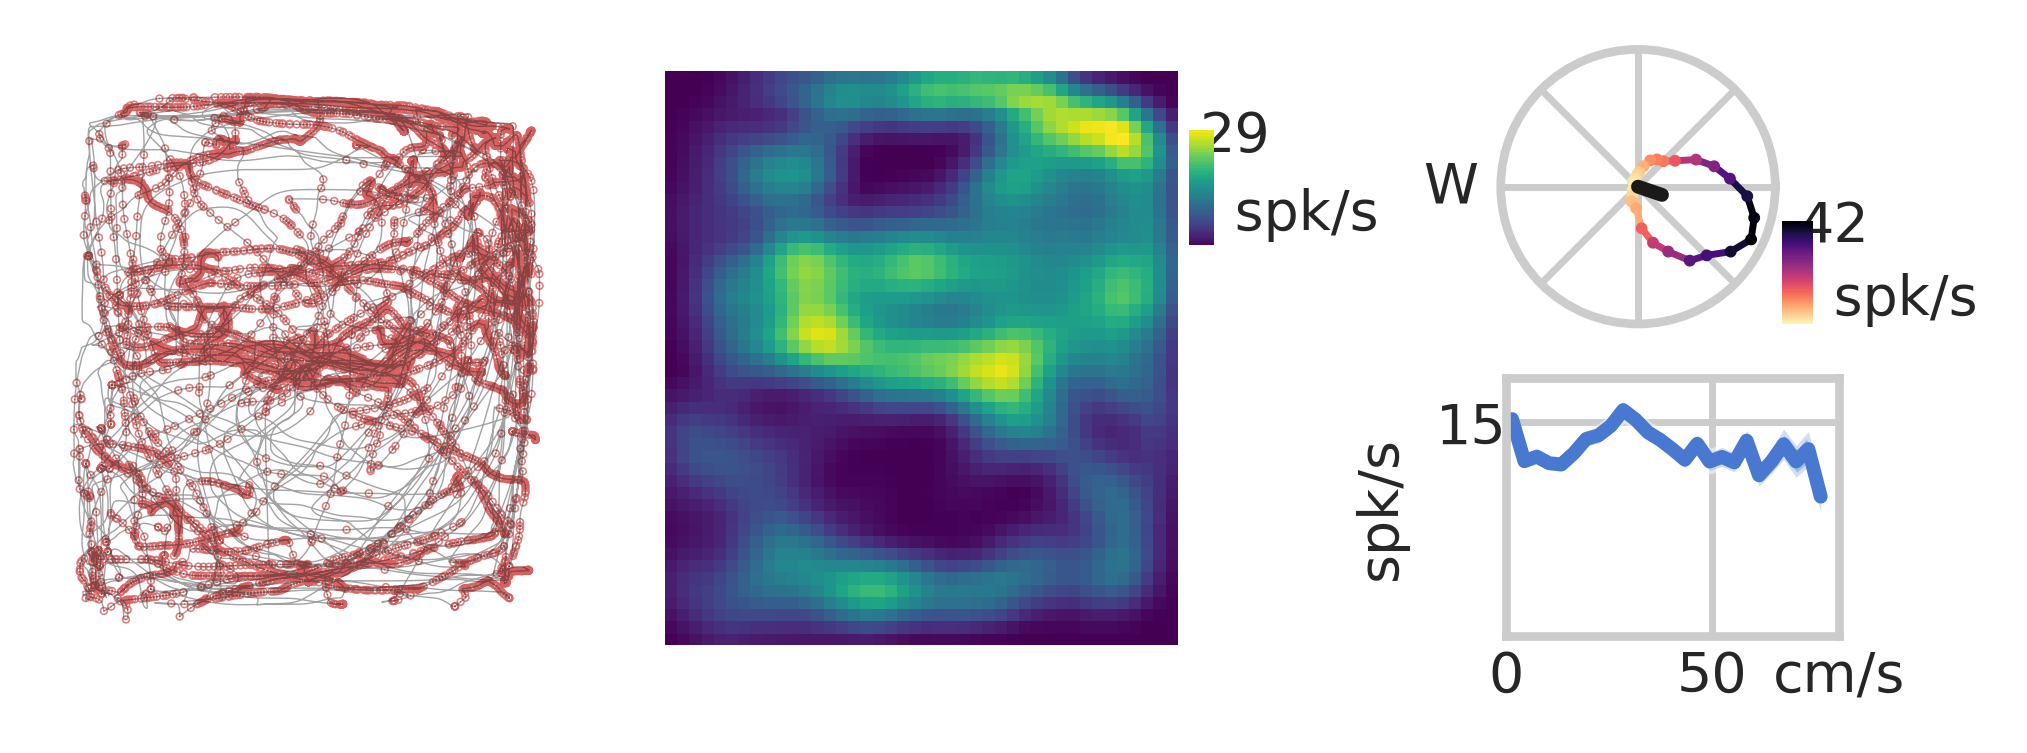

In [132]:
idx = 11767
sns.set_style("whitegrid")
cl_name = model_scores.loc[idx, 'cl_name']
f,ax = plot_OF_example_unit_final(cl_name, *load_cell(idx, model_scores))
f.savefig(fig5_path/(f'OF_Fits{uuid}.png'), bbox_inches='tight', dpi=600)

## Vennn Diagram for Overlap between task and open field identification of units.

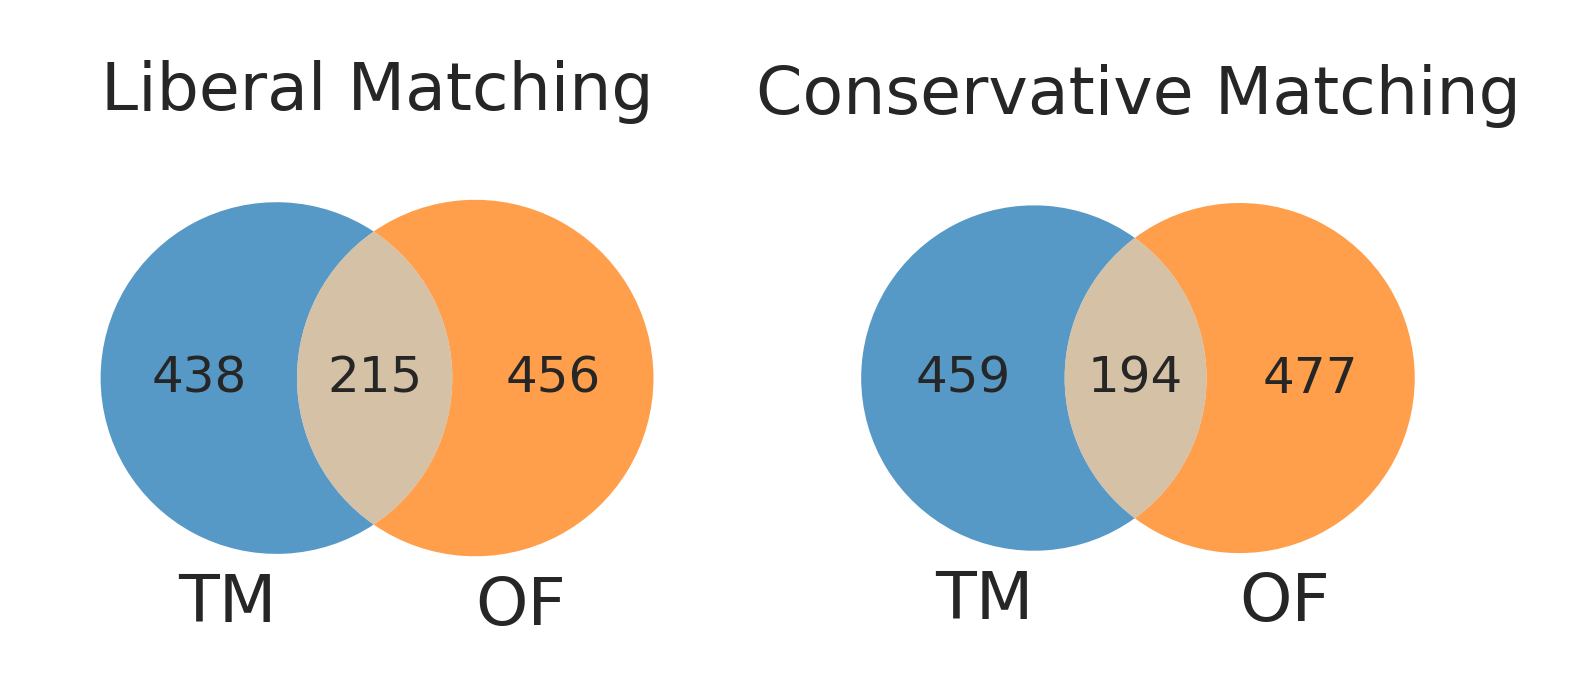

In [1403]:
n_TM_cells = unit_table[(unit_table.unit_type=='cell') & (unit_table.task2=='T3')].shape[0]
n_OF_cells = unit_table[(unit_table.unit_type=='cell') & (unit_table.task2=='OF')].shape[0]

n_matches_lib = unit_table.match_lib_multi_task_id.max()+1 
n_matches_con = unit_table.match_con_multi_task_id.max()+1

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

f, ax = plt.subplots(1,2, figsize=(3,1), dpi=600)
out = venn2( (n_TM_cells-n_matches_lib, n_OF_cells-n_matches_lib, n_matches_lib), 
            set_labels=['TM', 'OF'], set_colors=colors[:2], alpha=0.75, ax=ax[0])

for text in out.set_labels:
    text.set_fontsize(set_labels_fontsize)
for x in range(len(out.subset_labels)):
    if out.subset_labels[x] is not None:
        out.subset_labels[x].set_fontsize(set_fontsize)


out = venn2( (n_TM_cells-n_matches_con, n_OF_cells-n_matches_con, n_matches_con), 
            set_labels=['TM', 'OF'], set_colors=colors[:2], alpha=0.75, ax=ax[1])

for text in out.set_labels:
    text.set_fontsize(set_labels_fontsize)
for x in range(len(out.subset_labels)):
    if out.subset_labels[x] is not None:
        out.subset_labels[x].set_fontsize(set_fontsize)

label_fontsize=8
ax[0].set_title("Liberal Matching", fontsize=label_fontsize)
ax[1].set_title("Conservative Matching", fontsize=label_fontsize)


f.savefig(fig5_path/(f'ClusterMatchesXTasks.pdf'), bbox_inches='tight', dpi=600)
f.savefig(fig5_path/(f'ClusterMatchesXTasks.png'), bbox_inches='tight', dpi=600)